# Project Background
The company in this project is a UK-based e-commerce (online retail) selling gifts and homewares for adults and children through the website since 2007. The data type used is a sales transaction data set for one year (November 2018 to November 2019). According to the dataset's uploader, here's the description of each column:

1. `TransactionNo` (categorical): a six-digit unique number that defines each transaction. The letter “C” in the code indicates a cancellation.
2. `Date` (numeric): the date when each transaction was generated.
3. `ProductNo` (categorical): a five or six-digit unique character used to identify a specific product.
4. `Product` (categorical): product/item name.
5. `Price` (numeric): the price of each product per unit in pound sterling (£).
6. `Quantity` (numeric): the quantity of each product per transaction. Negative values related to cancelled transactions.
7. `CustomerNo` (categorical): a five-digit unique number that defines each customer.
8. `Country` (categorical): name of the country where the customer resides.
   
The company must identify potential customer segments to help target its market better and efficiently. This information will ensure that all future campaigns and marketing efforts are given to customers who demonstrate possible acceptances and purchases.

To determine the segments in the current customer base, we will use exploratory data analysis (EDA) and the k-means clustering algorithm. Then, we can identify the best customer segment using the RFM framework. Finally, we will propose several relevant business recommendations that cater to the best customer segment's characteristics.

# Environment and Data Setup
First, let's install and load the required libraries for this analysis.

In [1]:
# Libraries
!pip install country_converter --upgrade

import pandas as pd
import numpy as np
import country_converter as coco
import calendar

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score

# Silencing the warnings
import warnings
warnings.filterwarnings('ignore')

# Resetting the default matplotlib style (the style was changed because of the yellowbrick lib import)
from yellowbrick.style import reset_defaults, reset_orig 
reset_defaults()
reset_orig()

  Obtaining dependency information for country_converter from https://files.pythonhosted.org/packages/72/2a/0701fa1349dd2b26f368b758d38efa9a64138fe726ebeb188bf137d73988/country_converter-1.2-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.3 MB/s eta 0:00:00


Then, let's load the dataset.

In [2]:
# Dataset
df = pd.read_csv('/kaggle/input/an-online-shop-business/Sales Transaction v.4a.csv')

# Quick look
df.head()

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country
0,581482,12/9/2019,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom
1,581475,12/9/2019,22596,Christmas Star Wish List Chalkboard,10.65,36,13069.0,United Kingdom
2,581475,12/9/2019,23235,Storage Tin Vintage Leaf,11.53,12,13069.0,United Kingdom
3,581475,12/9/2019,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069.0,United Kingdom
4,581475,12/9/2019,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069.0,United Kingdom


Next, let's check the data types of all columns.

In [3]:
# Columns information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536350 entries, 0 to 536349
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionNo  536350 non-null  object 
 1   Date           536350 non-null  object 
 2   ProductNo      536350 non-null  object 
 3   ProductName    536350 non-null  object 
 4   Price          536350 non-null  float64
 5   Quantity       536350 non-null  int64  
 6   CustomerNo     536295 non-null  float64
 7   Country        536350 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 32.7+ MB


We can make several data type changes to make our EDA easier:
1. Change the `CustomerNo` to object because it doesn't mean anything numerically
2. Change the `Date` to be a datetime64 because, well, it is a date after all

Aside from these changes, we can see that the missing values only exist in the `CustomerNo` column. To be safe, let's check the total of missing values from each column.

*Disclaimer: The dataset doesn't seem to have a unique identifier for each row, plus the `TransactionNo` column has several repeating occurrences. Therefore, we cannot reliably check for duplicates in this dataset. The data take the long data form, where some repeating rows could occur in the dataset recording each individual transaction.*

In [4]:
# Initializing an empty dictionary to be filled with column name, missingness count, proportion
missingness = {}

# Loop to add the column name, missingness count, and the proportion of missing values across columns
for i in range(len(df.columns)):
    if i == 0:
        missingness['column'] = [df.columns[i]]
        missingness['missing_count'] = [df.isna().sum().tolist()[i]]
        missingness['prop'] = [df.isna().sum().tolist()[i]/df.shape[0]]
    else:
        missingness['column'] += [df.columns[i]]
        missingness['missing_count'] += [df.isna().sum().tolist()[i]]
        missingness['prop'] += [round((df.isna().sum().tolist()[i]/df.shape[0]) * 100, 2)]

# Converting the missingness dictionary to DataFrame
pd.DataFrame(missingness).sort_values('prop', ascending = False)

,column,missing_count,prop
6,CustomerNo,55,0.01
0,TransactionNo,0,0.00
1,Date,0,0.00
2,ProductNo,0,0.00
3,ProductName,0,0.00
4,Price,0,0.00
5,Quantity,0,0.00
7,Country,0,0.00


We can quickly dig deeper into the missingness in the `CustomerNo` column by comparing the statistical summary of other columns.

In [5]:
# Separating between missing and complete DataFrames
missing = df[df['CustomerNo'].isna()]
complete = df[~df['CustomerNo'].isna()]

# Summary statistics of missing data
missing.describe()

,Price,Quantity,CustomerNo
count,55.000000,55.000000,0.0
mean,14.135455,-34.490909,NaN
std,6.283330,74.857364,NaN
min,5.970000,-300.000000,NaN
25%,10.250000,-12.000000,NaN
50%,13.270000,-1.000000,NaN
75%,14.965000,-1.000000,NaN
max,44.250000,8.000000,NaN


In [6]:
# Summary statistics of complete data
complete.describe()

,Price,Quantity,CustomerNo
count,536295.000000,536295.000000,536295.000000
mean,12.662031,9.923902,15227.893178
std,8.490638,216.671641,1716.582932
min,5.130000,-80995.000000,12004.000000
25%,10.990000,1.000000,13807.000000
50%,11.940000,3.000000,15152.000000
75%,14.090000,10.000000,16729.000000
max,660.620000,80995.000000,18287.000000


Many transactions with missing customer numbers have negative quantities, which means the orders were cancelled (according to the dataset documentation). This pattern suggests that missing customer numbers are more likely in cancelled orders. Since only 55 of the total records (less than 1%) have missing customer numbers, it is safe to remove these records.

In [7]:
# Dropping records with missing CustomerNo
df.dropna(subset = ['CustomerNo'], inplace = True)

Now that we have treated the missing records, let's make the changes mentioned earlier.

In [8]:
# Changing CustomerNo and Date dtypes
df['CustomerNo'] = df['CustomerNo'].astype('int').astype('object')
df['Date'] = pd.to_datetime(df['Date'])

Before we step further into the EDA process, we will analyse successful transactions only for our RFM clustering analysis. Therefore, we need to drop cancelled transactions with 'C' as the prefix of `TransactionNo`.

In [9]:
# Separating both cancelled and successful transactions dataframe
success_df = df[~df['TransactionNo'].str.startswith('C')]

## Feature Creation & Extraction

**Revenue**

After having a quick look at the columns, we have two columns that could produce a new feature: `Price` * `Quantity` that translates into `Revenue`. From now on, we'll use `success_df` as our main DataFrame.

In [10]:
# Adding a new feature: Revenue
success_df['Revenue'] = success_df['Price'] * success_df['Quantity']

**Day of Week, Month, and Year**

We will also extract the day of the week, month, and year features to investigate the transactions' trend later in the EDA phase.

*Note:* 
- The reason why we save them as a category is to preserve memory usage because category type is more small in memory than an object
- Pandas day of the week starts from 0 (Monday) through 6 (Sunday)

In [11]:
# Adding day of week
success_df['DayOfWeek'] = success_df['Date'].dt.dayofweek.astype('category')

# Adding month
success_df['Month'] = success_df['Date'].dt.month.astype('category')

# Adding year
success_df['Year'] = success_df['Date'].dt.year.astype('category')

**Country ISO3 Code**

To facilitate the creation of choropleth maps later on, we'll need to create a new column containing the ISO3 code for each country. We will need the abbreviated form of country names in visualizing data on a geographical scale.

In [12]:
# Getting the unique values from country
countries = success_df['Country'].unique()

# Converting unique values from country to ISO3
iso3_countries = [coco.convert(country, to = 'ISO3') for country in countries]

# Treating several non-standard country names
res = dict(zip(countries, iso3_countries))
for i in res.keys():
    if i == 'EIRE':
        res[i] = 'IRL'
    elif i == 'Channel Islands':
        res[i] = 'GB-CHA'
    elif i == 'RSA':
        res[i] = 'ZAF'
    elif i in ('Unspecified', 'European Community'): # European community contains many countries! So we'll assume this'll be missing
        res[i] = np.nan

# Mapping the ISO3 results to DataFrame
success_df['CountryISO3'] = success_df['Country'].map(res)

For clarity, we revised some of the non-standard country names, namely:
1. EIRE - Ireland (IRL)
2. Channel Islands - ISO3 Code = GB-CHA
3. RSA - South Africa (ZAF)

Additionally, we have replaced countries with 'Unspecified' values with NaN. Countries with the value 'European Community', which consists of multiple countries, are also treated as NaN to maintain consistency in data representation.

Let's look at our DataFrame before going into the EDA phase.

In [13]:
# Quick look
success_df.head()

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,Revenue,DayOfWeek,Month,Year,CountryISO3
0,581482,2019-12-09,22485,Set Of 2 Wooden Market Crates,21.47,12,17490,United Kingdom,257.64,0,12,2019,GBR
1,581475,2019-12-09,22596,Christmas Star Wish List Chalkboard,10.65,36,13069,United Kingdom,383.40,0,12,2019,GBR
2,581475,2019-12-09,23235,Storage Tin Vintage Leaf,11.53,12,13069,United Kingdom,138.36,0,12,2019,GBR
3,581475,2019-12-09,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069,United Kingdom,127.80,0,12,2019,GBR
4,581475,2019-12-09,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069,United Kingdom,71.64,0,12,2019,GBR


# EDA: Univariate Analysis
## Summary Statistics
Let's first see the summary statistics of numeric columns in our dataset.

In [14]:
# Numerical summary statistics
success_df.describe().round(2)

,Date,Price,Quantity,Revenue
count,527764,527764.00,527764.00,527764.00
mean,2019-07-04 05:58:58.445213952,12.63,10.59,119.31
min,2018-12-01 00:00:00,5.13,1.00,5.13
25%,2019-03-28 00:00:00,10.99,1.00,17.17
50%,2019-07-20 00:00:00,11.94,3.00,43.83
75%,2019-10-19 00:00:00,14.09,11.00,119.40
max,2019-12-09 00:00:00,660.62,80995.00,1002718.10
std,NaN,7.93,156.79,1851.19


Observation results:
- **Date Range:** The dataset spans from December 1, 2018, to December 9, 2019.
- **Potential Outliers:** The `Price`, `Quantity`, and `Revenue` columns show potential outliers (extreme values), indicating the presence of a few unusually large transactions.
- **Skewed Distributions:** The `Price`, `Quantity`, and `Revenue` columns indicate a right-skewed distribution, where their mean is higher than their median. This distribution suggests that several transactions involve higher product prices, quantities and revenue than the typical transaction.

According to the data source, we can assume that some extremely high values in the `Quantity` and `Revenue` columns are transactions from small businesses that buy in bulk and sell to other customers through retail outlet channels. We'll check with the box plot to see which transactions have these unusual values accurately.

*Note: We will conduct the outlier handling during the preprocessing stage. The `Price` feature does have some exceptionally high values, but their distance from the typical range is not as extreme as that of `Quantity` and `Revenue`.*

Next, let's see our dataset's summary statistics of categorical/string columns.

In [15]:
success_df.describe(include = ['object', 'category'])

,TransactionNo,ProductNo,ProductName,CustomerNo,Country,DayOfWeek,Month,Year,CountryISO3
count,527764,527764,527764,527764,527764,527764,527764,527764,527260
unique,19789,3753,3753,4718,38,6,12,2,36
top,573585,85123A,Cream Hanging Heart T-Light Holder,17841,United Kingdom,6,11,2019,GBR
freq,1111,2336,2336,7835,477770,100509,83042,486347,477770


Observation results:
- **Top Product:** The product with the highest sales volume is the Cream Hanging Heart T-Light Holder, accounting for 2,336 transactions.
- **Popular Country**: Most customers, representing 90% of all transactions, originated from the United Kingdom.
- **Top Transaction Month**: November emerged as the month with the most transactions, recording an impressive 83,042 transactions.
- **Busiest Weekday**: Sunday was the most popular day for transactions, showing a remarkable 100,509 transactions.

## Distributions
First, let's see the distribution of all numeric variables using box plots.

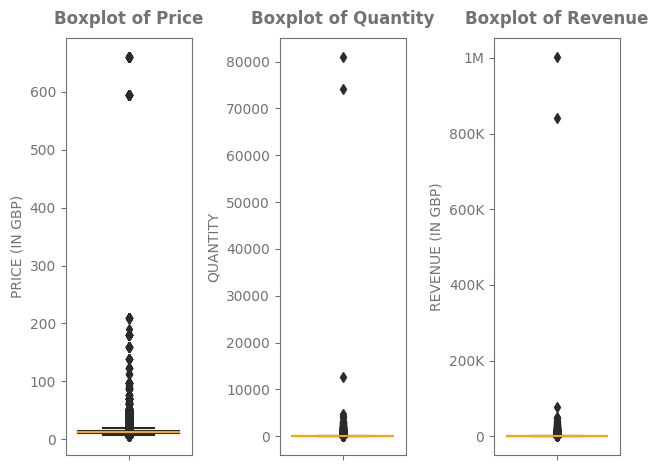

In [16]:
# Getting the numeric variables
nums = success_df.select_dtypes(exclude = ['object', 'datetime64[ns]', 'category']).columns.tolist()

# Setting the figure and axes
fig, ax = plt.subplots(1, 3)

# Box plots of numeric columns
for i in range(len(nums)):
    
    # Creating the box plot
    sns.boxplot(data = success_df, y = nums[i], color = 'darkblue', 
                medianprops = dict(color = 'orange'), ax = ax[i])
    
    # Customization for the 'Price' box plot
    if nums[i] == 'Price':
        ax[i].set_ylabel('PRICE (IN GBP)', color = '#6F7378')
        
    # Customization for the 'Quantity' box plot
    elif nums[i] == 'Quantity':
        ax[i].set_ylabel('QUANTITY', color = '#6F7378')
        
    # Customization for the 'Revenue' box plot
    else:
        ax[i].set_yticks(range(0, 1000001, 200000), labels = ['0', '200K', '400K', '600K', '800K', '1M'])
        ax[i].set_ylabel('REVENUE (IN GBP)', color = '#6F7378')
    
    # Changing the tick color
    ax[i].tick_params(color = '#6F7378') 
    
    # Changing the x and y tick labels colors
    plt.setp(ax[i].get_xticklabels(), color = '#6F7378') 
    plt.setp(ax[i].get_yticklabels(), color = '#6F7378') 
    
    # Changing the spines colors
    for spine in ax[i].spines.values():
        spine.set_edgecolor('#6F7378')

    # Adding plot title
    ax[i].set_title(f'Boxplot of {nums[i]}', weight = 'bold', color = '#6F7378', pad = 10)

# Showing the figure with a tight layout
plt.tight_layout()

Due to global outliers or extreme values, it's challenging to accurately determine the central tendency of the `Price`, `Quantity`, and `Revenue` columns. To better visualize the distribution of the majority of the data, we can temporarily adjust the y-axis limit to focus on the box part of the plot.

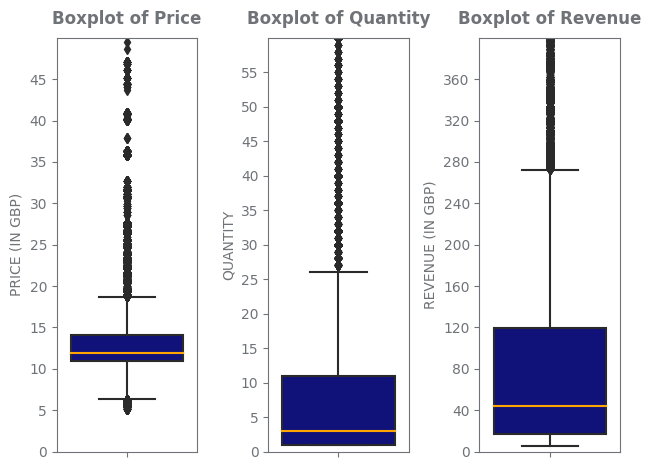

In [17]:
# Getting the numeric variables
nums = success_df.select_dtypes(exclude = ['object', 'datetime64[ns]', 'category']).columns.tolist()

# Setting the figure and axes
fig, ax = plt.subplots(1, 3)

# Box plots of numeric columns
for i in range(len(nums)):
    
    # Creating the box plot
    sns.boxplot(data = success_df, y = nums[i], color = 'darkblue', 
                medianprops = dict(color = 'orange'), ax = ax[i])
    
    # Customization for the 'Price' box plot
    if nums[i] == 'Price':
        ax[i].set_ylabel('PRICE (IN GBP)', color = '#6F7378')
        ax[i].set_ylim([0, 50])
        ax[i].set_yticks(range(0, 50, 5))
        
    # Customization for the 'Quantity' box plot
    elif nums[i] == 'Quantity':
        ax[i].set_ylabel('QUANTITY', color = '#6F7378')
        ax[i].set_ylim([0, 60])
        ax[i].set_yticks(range(0, 60, 5))
        
    # Customization for the 'Revenue' box plot
    else:
        ax[i].set_ylabel('REVENUE (IN GBP)', color = '#6F7378')
        ax[i].set_ylim([0, 400])
        ax[i].set_yticks(range(0, 400, 40))
    
    # Changing the tick color
    ax[i].tick_params(color = '#6F7378') 
    
    # Changing the x and y tick labels colors
    plt.setp(ax[i].get_xticklabels(), color = '#6F7378') 
    plt.setp(ax[i].get_yticklabels(), color = '#6F7378') 
    
    # Changing the spines colors
    for spine in ax[i].spines.values():
        spine.set_edgecolor('#6F7378')

    # Adding plot title
    ax[i].set_title(f'Boxplot of {nums[i]}', weight = 'bold', color = '#6F7378', pad = 10)

# Showing the figure with a tight layout
plt.tight_layout()

Now that the box part of the plot is more visible, we can infer the following:
- The typical `Price` range falls between approximately 11 GBP and 14 GBP. However, there are outliers below roughly 10 GBP and above 15 GBP, with some reaching as high as over 500 GBP.
- The typical `Quantity` for transactions ranges from 1 to approximately 11. While some outliers exceed 26 in quantity, two exceptional cases reach over 70,000 units.
- The typical `Revenue` generated by these e-commerce transactions falls between slightly below 20 GBP and roughly 120 GBP. However, some outliers generate over 300 GBP, with two outliers surpassing 800,000 GBP.

**INTERIM ACTION: DEALING WITH EXTREME BULK TRANSACTIONS**

As noted earlier, the numerical summary statistics revealed several unusually large transactions with extreme `Quantity` and `Revenue` values. We'll temporarily remove these extreme values before proceeding to ensure a more accurate and comprehensive Exploratory Data Analysis (EDA). Based on the boxplot analysis, these transactions have the following characteristics:

- Quantity: Exceeding 70,000 items
- Revenue: Surpassing 800,000 GBP

Let's delve into these transactions to understand their nature further.


In [18]:
# Finding records with extreme bulk transactions as described above
success_df[(success_df['Quantity'] > 70000) | (success_df['Revenue'] > 800000)]

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,Revenue,DayOfWeek,Month,Year,CountryISO3
142,581483,2019-12-09,23843,Paper Craft Little Birdie,12.38,80995,16446,United Kingdom,1002718.1,0,12,2019,GBR
473985,541431,2019-01-18,23166,Medium Ceramic Top Storage Jar,11.32,74215,12346,United Kingdom,840113.8,4,1,2019,GBR


A closer examination reveals that two customers are responsible for these bulk transactions. They purchased exceptionally high quantities of souvenirs, including Paper Craft Little Birdie and Medium Ceramic Top Storage Jar, leading to inflated revenue figures. For now, we'll remove these transactions from our analysis to focus on the more representative portion of the data.

In [19]:
# Finding out records with extreme bulk transactions 
success_df = success_df[~(success_df['Quantity'] > 70000) | ~(success_df['Revenue'] > 800000)]

Now, let's continue the exploration using histograms.

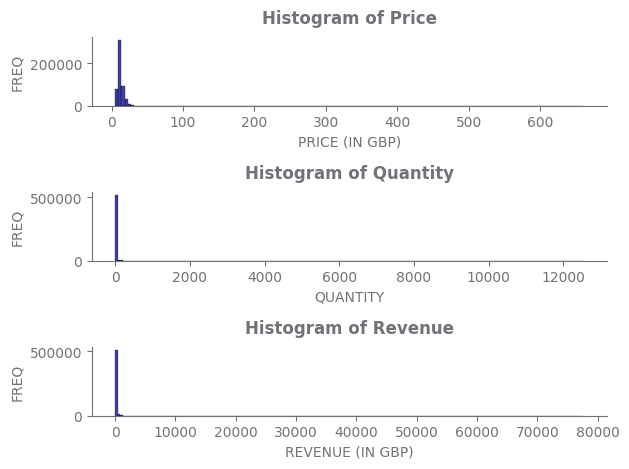

In [20]:
# Setting the figure and axes
fig, ax = plt.subplots(3, 1)

# Loop to create the histograms
for i in range(len(nums)):
    
    # Creation and customization for the 'Price' histogram
    if nums[i] == 'Price':
        sns.histplot(x = nums[i], data = success_df, color = 'darkblue', bins = 150, ax = ax[i])
        ax[i].set_xlabel('PRICE (IN GBP)', color = '#6F7378')
        
    # Creation and customization for the 'Quantity' box plot
    elif nums[i] == 'Quantity':
        sns.histplot(x = nums[i], data = success_df, color = 'darkblue', bins = 180, ax = ax[i])
        ax[i].set_xlabel('QUANTITY', color = '#6F7378')
        
    # Creation and customization for the 'Revenue' box plot
    else:
        sns.histplot(x = nums[i], data = success_df, color = 'darkblue', bins = 180, ax = ax[i])
        ax[i].set_xlabel('REVENUE (IN GBP)', color = '#6F7378')
    
    # Customizing the y label
    ax[i].set_ylabel('FREQ', color = '#6F7378')
    
    # Removing the top and right spines
    sns.despine(right = True)
    
    # Changing the tick color
    ax[i].tick_params(color = '#6F7378') 
    
    # Changing the x and y tick labels colors
    plt.setp(ax[i].get_xticklabels(), color = '#6F7378') 
    plt.setp(ax[i].get_yticklabels(), color = '#6F7378') 
    
    # Changing the spines colors
    for spine in ax[i].spines.values():
        spine.set_edgecolor('#6F7378')

    # Adding plot title
    ax[i].set_title(f'Histogram of {nums[i]}', weight = 'bold', color = '#6F7378', pad = 10)

# Showing the figure with a tight layout
plt.tight_layout()        

Once again, the distribution shape isn't apparent because of the high global outliers in all numeric variables, but we can see that they are right-skewed. Let's confirm this further using the measure of skewness.

In [21]:
success_df.skew(numeric_only = True)

Price       53.190089
Quantity    77.349361
Revenue     41.682883
dtype: float64

We can confirm that all numeric variables are extremely right-skewed, with `Quantity` being the most obvious.

Before going into the distribution of our categorical variables, let's first examine the number of unique values each variable has. This examination will provide an initial understanding of the diversity of the categorical data.

In [22]:
cats = success_df.select_dtypes(include = ['object', 'category']).columns.tolist()

for i in cats:
    display(success_df[i].value_counts())
    print(f'Unique values: {len(success_df[i].unique())} \n')

TransactionNo
573585    1111
581219     747
581492     730
580729     720
558475     704
          ... 
539989       1
556249       1
539987       1
571008       1
536585       1
Name: count, Length: 19787, dtype: int64

Unique values: 19787 



ProductNo
85123A    2336
85099B    2115
22423     2019
47566     1708
20725     1597
          ... 
90187A       1
84809B       1
90100        1
21414        1
82615        1
Name: count, Length: 3752, dtype: int64

Unique values: 3752 



ProductName
Cream Hanging Heart T-Light Holder     2336
Jumbo Bag Red Retrospot                2115
Regency Cakestand 3 Tier               2019
Party Bunting                          1708
Lunch Bag Red Retrospot                1597
                                       ... 
Blue Drop Earrings W Bead Cluster         1
Pink Chrysanthemums Art Flower            1
Necklace+Bracelet Set Pink Daisy          1
Scallop Shell Soap Dish                   1
Pink Marshmallow Scarf Knitting Kit       1
Name: count, Length: 3752, dtype: int64

Unique values: 3752 



CustomerNo
17841    7835
14911    5580
14096    5093
12748    4584
14606    2692
         ... 
13120       1
16144       1
12081       1
15040       1
17558       1
Name: count, Length: 4717, dtype: int64

Unique values: 4717 



Country
United Kingdom          477768
France                   10393
Germany                  10240
EIRE                      7807
Belgium                   2507
Spain                     2386
Netherlands               2326
Switzerland               2303
Portugal                  1838
Australia                 1631
Norway                     927
Austria                    884
Iceland                    787
Finland                    686
Italy                      624
Channel Islands            620
Cyprus                     576
Unspecified                447
Sweden                     408
Denmark                    408
Israel                     358
Japan                      337
USA                        267
Singapore                  215
Poland                     173
Hong Kong                  153
Canada                     150
Malta                      135
Greece                      67
United Arab Emirates        67
RSA                         57
European Community          57


Unique values: 38 



DayOfWeek
6    100509
4     99114
3     92675
5     91889
0     79833
2     63742
Name: count, dtype: int64

Unique values: 6 



Month
11    83042
12    66428
10    59041
9     49007
7     38398
5     36015
6     35806
3     35644
8     34318
1     34136
4     28936
2     26991
Name: count, dtype: int64

Unique values: 12 



Year
2019    486345
2018     41417
Name: count, dtype: int64

Unique values: 2 



CountryISO3
GBR       477768
FRA        10393
DEU        10240
IRL         7807
BEL         2507
ESP         2386
NLD         2326
CHE         2303
PRT         1838
AUS         1631
NOR          927
AUT          884
ISL          787
FIN          686
ITA          624
GB-CHA       620
CYP          576
SWE          408
DNK          408
ISR          358
JPN          337
USA          267
SGP          215
POL          173
HKG          153
CAN          150
MLT          135
ARE           67
GRC           67
ZAF           57
LBN           45
LTU           34
BRA           31
CZE           24
BHR           17
SAU            9
Name: count, dtype: int64

Unique values: 37 



To effectively visualize the distributions of our categorical variables, we'll use different strategies based on their characteristics:
- For variables with a large number of unique values like `TransactionNo`, `ProductNo`, `ProductName`, `CustomerNo`, and `Country`, directly visualizing their distributions would result in cluttered and difficult-to-interpret plots. Hence, we'll explore each variable's top 10 most frequent values.
- Instead of exploring `ProductNo`, a numerical identifier, we'll focus on visualizing the distribution of `ProductName`, as it provides more meaningful insights into the product characteristics and their popularity.
- For the remaining categorical variables, including `DayOfWeek`, `Month`, and `Year`, we'll utilize count plots as usual to effectively visualize their distributions and identify any notable patterns or trends.

Now, let's first see the top 10 distributions of `TransactionNo` and `CustomerNo`.

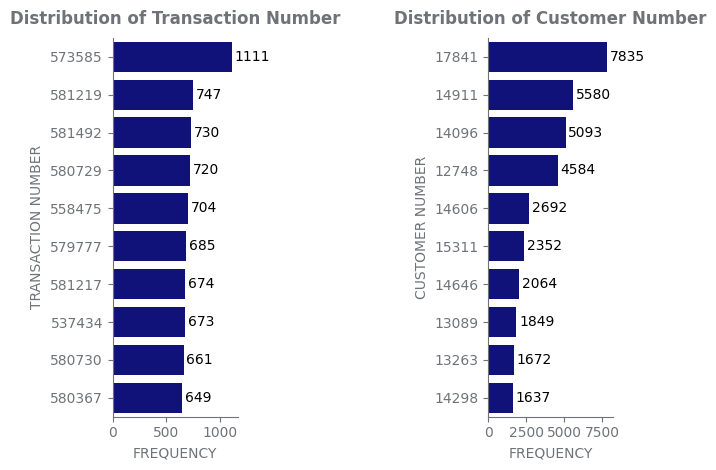

In [23]:
# Creating a list of the required variables
cols = ['TransactionNo', 'CustomerNo']

# Setting the figure and axes
fig, ax = plt.subplots(1, 2)

# Loop to create the plot
for i in range(len(cols)):
    
    # Creating the count plot
    sns.countplot(y = success_df[cols[i]],
                  order = success_df[cols[i]].value_counts().iloc[:10].index,
                  color = 'darkblue', ax = ax[i])
    
    # Setting the bar labels
    ax[i].bar_label(ax[i].containers[0], padding = 2)
        
    # Setting x labels for each plot
    ax[i].set_xlabel('FREQUENCY', color = '#6F7378')
        
    # Changing the tick color
    ax[i].tick_params(color = '#6F7378') 
    
    # Changing the x and y tick labels colors
    plt.setp(ax[i].get_xticklabels(), color = '#6F7378') 
    plt.setp(ax[i].get_yticklabels(), color = '#6F7378')
    
    # Changing the spines colors
    for spine in ax[i].spines.values():
        spine.set_edgecolor('#6F7378')
    
    # Removing the top and right spines
    sns.despine(right = True)
    
    # Y label and title customization for the TransactionNo count plot
    if cols[i] == 'TransactionNo':
        ax[i].set_ylabel('TRANSACTION NUMBER', color = '#6F7378')
        ax[i].set_title('Distribution of Transaction Number', pad = 10,
                        weight = 'bold', color = '#6F7378')
        
    # Y label and title customization for the CustomerNo count plot
    else:
        ax[i].set_ylabel('CUSTOMER NUMBER', color = '#6F7378')
        ax[i].set_title('Distribution of Customer Number', pad = 10,
                        weight = 'bold', color = '#6F7378')
        ax[i].set_xticks(range(0, 7501, 2500))
    
# Automatically create more space between plots
plt.tight_layout()

# Adjusting the width space
plt.subplots_adjust(wspace = 2)

Transaction number 573585 has the highest frequency, accounting for over 1,000 transactions alone. Customer 17841 emerges as the most loyal customer, having made over 7500 transactions between late 2018 and 2019. Due to the absence of customer data/tables, we cannot delve deeper into their characteristics, which limits our analysis.

Next, let's explore the top 10 most frequent countries and product names (`Country` and `ProductName` columns). This exploration will provide insights into the geographical distribution of transactions and the most popular products purchased.

First, we'll look at this dataset's top 10 most frequent countries.

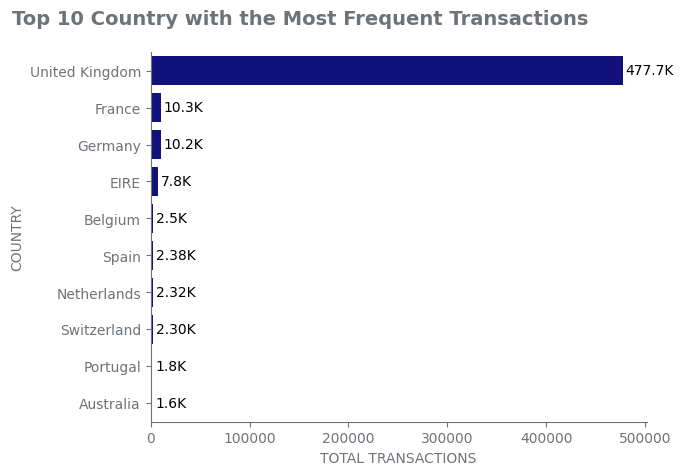

In [24]:
# Setting the figure and axes
fig, ax = plt.subplots()

# Plotting the countplot of 10 most frequent countries in the dataset
sns.countplot(y = success_df['Country'], order = success_df['Country'].value_counts().iloc[:10].index,
              color = 'darkblue')

# Removing the top and right spines
sns.despine(right = True)

# Adding bar labels
ax.bar_label(ax.containers[0], padding = 2, 
             labels = ['477.7K', '10.3K', '10.2K', '7.8K', '2.5K', 
                       '2.38K', '2.32K', '2.30K', '1.8K', '1.6K'])

# Changing the tick color
ax.tick_params(color = '#6F7378') 

# Changing the x and y tick labels colors
plt.setp(ax.get_xticklabels(), color = '#6F7378') 
plt.setp(ax.get_yticklabels(), color = '#6F7378') 

# Setting the label names of both axes
ax.set_xlabel('TOTAL TRANSACTIONS', color = '#6F7378')
ax.set_ylabel('COUNTRY', color = '#6F7378')

# Changing the spines colors
for spine in ax.spines.values():
    spine.set_edgecolor('#6F7378')    

# Adding plot title
ax.set_title('Top 10 Country with the Most Frequent Transactions', pad = 20, x = -0.28, 
             size = 14, weight = 'bold', color = '#6F7378', ha = 'left')

# Showing the plot
plt.show()

Consistent with the summary statistics, the United Kingdom dominates the transaction frequency, accounting for an impressive 90% of all transactions (obviously because the UK is the base of this e-commerce). However, several other countries, including France, Germany, and Ireland (EIRE), hold notable proportions of the dataset.

Next, let's see the top 10 products with the most purchases in the overall transactions.

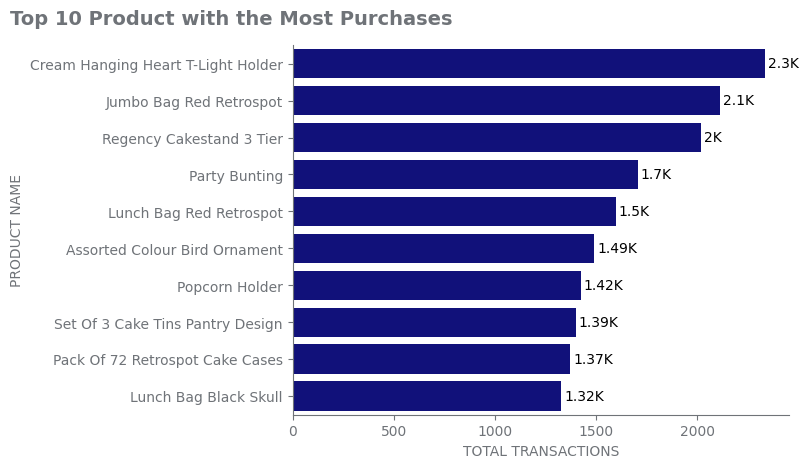

In [25]:
# Setting the figure and axes
fig, ax = plt.subplots()

# Plotting the count plot of top 10 most frequent product purchased
sns.countplot(y = success_df['ProductName'], 
              order = success_df['ProductName'].value_counts().iloc[:10].index,
              color = 'darkblue')

# Removing the top and right spines
sns.despine(right = True)

# Adding bar labels
bl = ax.bar_label(ax.containers[0], color = 'black', padding = 2,
             labels = ['2.3K', '2.1K', '2K', '1.7K', '1.5K', 
                       '1.49K', '1.42K' ,'1.39K', '1.37K', '1.32K'])

# Changing the tick color
ax.tick_params(color = '#6F7378') 

# Changing the x and y tick labels colors
plt.setp(ax.get_xticklabels(), color = '#6F7378') 
plt.setp(ax.get_yticklabels(), color = '#6F7378') 

# Setting the label names of both axes
ax.set_xlabel('TOTAL TRANSACTIONS', color = '#6F7378')
ax.set_ylabel('PRODUCT NAME', color = '#6F7378')

# Changing the spines colors
for spine in ax.spines.values():
    spine.set_edgecolor('#6F7378')

# Adding plot title
ax.set_title('Top 10 Product with the Most Purchases', pad = 15, x = -0.57, 
             size = 14, weight = 'bold', color = '#6F7378', ha = 'left')

# Showing the plot
plt.show()

These top-selling products fall into three categories: home décor, party supplies, and food and kitchen items. The Cream Hanging Heart T-Light Holder is the most popular product from 2018 to 2019.

Now, let's explore the `DayOfWeek`, `Month`, and `Year` variables.

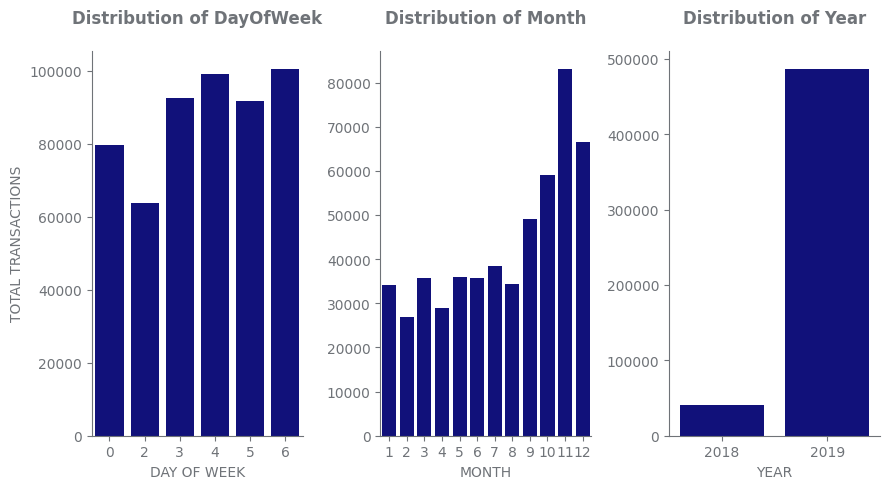

In [26]:
# Creating a list of categorical variable names 
cats = ['DayOfWeek', 'Month', 'Year']

# Setting the figure and axes
fig, ax = plt.subplots(1, 3, figsize = (9, 5))

# Loop to create a bar plot for each categorical variable
for i in range(len(cats)):
    # Plotting the countplot
    sns.countplot(x = cats[i], data = success_df, color = 'darkblue', ax = ax[i])
    
    # Setting each plot's title
    ax[i].set_title(f'Distribution of {cats[i]}', pad = 20, weight = 'bold', color = '#6F7378')
    
    # Setting different x and y labels for each plot
    if i == 0:
        ax[i].set_ylabel('TOTAL TRANSACTIONS', color = '#6F7378')
        ax[i].set_xlabel('DAY OF WEEK', color = '#6F7378')
    elif i == 1:
        ax[i].set_ylabel('')
        ax[i].set_xlabel('MONTH', color = '#6F7378')
    else:
        ax[i].set_ylabel('')
        ax[i].set_xlabel('YEAR', color = '#6F7378')
        
    # Changing the tick color
    ax[i].tick_params(color = '#6F7378') 
    
    # Changing the x and y tick labels colors
    plt.setp(ax[i].get_xticklabels(), color = '#6F7378') 
    plt.setp(ax[i].get_yticklabels(), color = '#6F7378') 
    
    # Changing the spines colors
    for spine in ax[i].spines.values():
        spine.set_edgecolor('#6F7378')
        
    # Removing the top and right spines
    sns.despine(right = True)

plt.tight_layout()

We can observe the following from the plots above:
- **Day of the Week Transactions**: The absence of transactions on Tuesdays suggests that the e-commerce platform is closed on Tuesdays, or there might be a data gap for transactions on that day. Interestingly, Fridays and Sundays are the days with the highest transaction volume.
- **Monthly Transactions**: A clear trend emerges from the 'Month' variable, indicating a steady increase in transactions towards the end of the year. November is the month with the highest transaction volume. This seasonal pattern could be attributed to holiday shopping and increased consumer spending during that time of year.
- **Yearly Transactions**: While the 'Year' variable shows a significant jump in transactions between 2018 and 2019, it's important to note that the 2018 data only includes transactions from December. Therefore, we cannot definitively conclude whether there was a genuine increase in transactions between 2018 and 2019 without an entire year's worth of data for both years. Further investigation would be required to determine if this trend persists throughout the year.

# EDA: Bivariate & Multivariate Analysis
## Numerical Relationships

We'll begin our exploration by examining the relationships between numerical variables. We have the following variables that are of the numerical type:
1. `Revenue`
2. `Quantity`
3. `Price`

Let's investigate the correlation coefficients to assess the strength and direction of linear relationships between these variables.

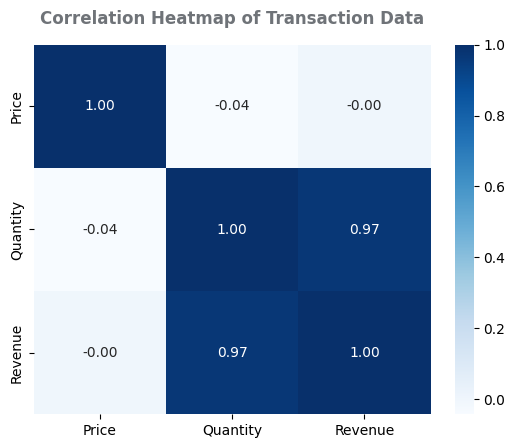

In [27]:
# Setting the figure and axes
fig, ax = plt.subplots()

# Creating the correlation heatmap
sns.heatmap(success_df.corr(numeric_only = True), annot = True, cmap = 'Blues', fmt = '.2f', ax = ax)

# Adding plot title
ax.set_title('Correlation Heatmap of Transaction Data', pad = 15, weight = 'bold', color = '#6F7378')

# Showing the plot
plt.show()

The only variables that show a strong positive correlation are `Revenue` and `Quantity`. This relationship is intuitive, as an increase in `Quantity` directly translates into higher `Revenue`.

Let's check the relationships between numerical data using a pair plot.

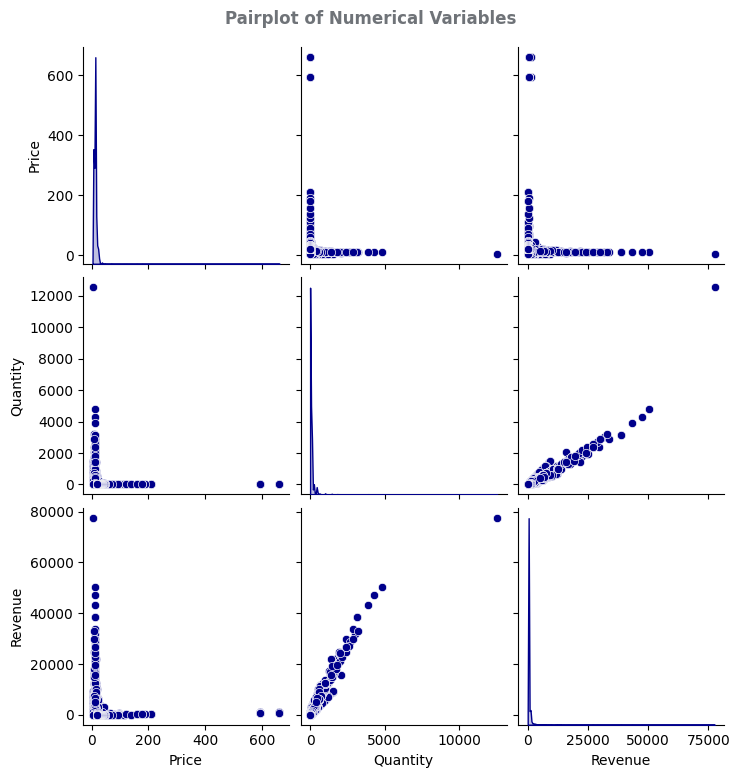

In [28]:
# Creating the pairplot
g = sns.pairplot(success_df[['Price', 'Quantity', 'Revenue']], diag_kind = 'kde', 
             plot_kws = dict(color = 'darkblue'), diag_kws = dict(color = 'darkblue'))

# Adding title
g.fig.suptitle('Pairplot of Numerical Variables', weight = 'bold', color = '#6F7378', y = 1.03)

# Showing the plot
plt.show()

The strong positive relationship between `Quantity` and `Revenue` is further evident in the corresponding scatter plot. However, it's worth noting the presence of an outlier, a transaction with a quantity exceeding 10,000, resulting in a revenue of 800,000 GBP. This outlier suggests the existence of an exceptionally large or unique purchase that doesn't reflect the overall trend of the relationship. Apart from `Quantity` and `Revenue`, no other variables show clear and significant relationships.

## Transaction Sales Performance
Next, we'll delve into the temporal aspect of transactions by analyzing the performance of `Revenue` over time. Since `Revenue` was calculated from both `Price` and `Quantity`, it comprehensively represents sales performance and transaction patterns.

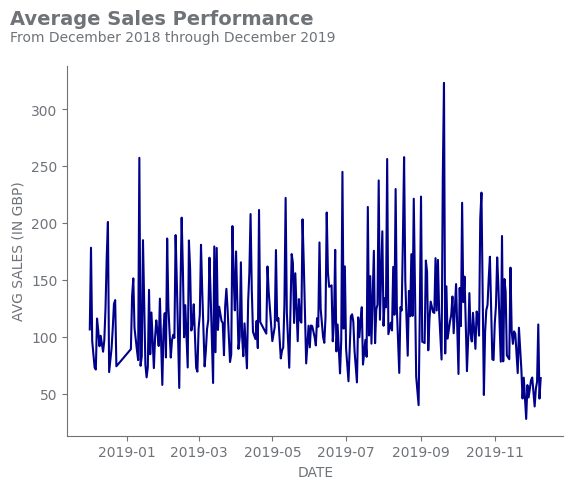

In [29]:
# Setting the figure and axes
fig, ax = plt.subplots()

# Plotting the sales trend across dates
sns.lineplot(x = 'Date', y = 'Revenue', data = success_df, ci = None, color = 'darkblue', ax = ax)

# Removing the top and right spines
sns.despine(right = True)

# Changing the tick color
ax.tick_params(color = '#6F7378') 

# Changing the x and y tick labels colors
plt.setp(ax.get_xticklabels(), color = '#6F7378') 
plt.setp(ax.get_yticklabels(), color = '#6F7378') 

# Setting the label names of both axes
ax.set_xlabel('DATE', color = '#6F7378')
ax.set_ylabel('AVG SALES (IN GBP)', color = '#6F7378')

# Changing the spines colors
for spine in ax.spines.values():
    spine.set_edgecolor('#6F7378')

# Adding plot title and subtitle
ax.set_title('Average Sales Performance', pad = 30, size = 14, x = -0.115, 
             weight = 'bold', color = '#6F7378', ha = 'left')
ax.text(s = 'From December 2018 through December 2019', x = pd.Timestamp('2018-09-26'), 
        y = 360, color = '#6F7378')

# Showing the plot
plt.show()

The overall sales trend across the dataset reveals a somewhat stationary pattern, with a slight downward inclination towards the end of 2019. Interestingly, a notable spike in sales occurred around September-October 2019. We'll delve into monthly and daily sales trends for a more detailed analysis.

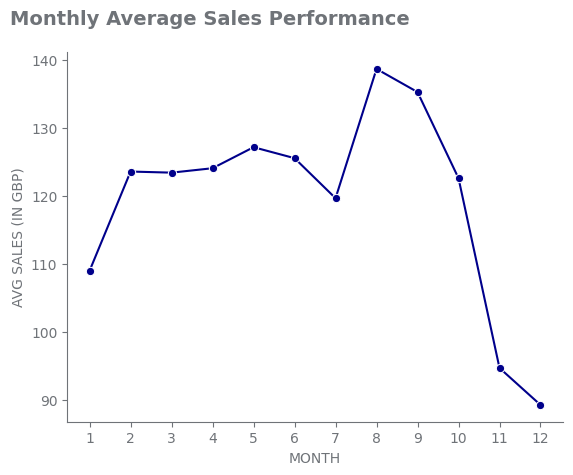

In [30]:
# Setting the figure and axes
fig, ax = plt.subplots()

# Plotting the monthly sales trend
sns.lineplot(x = 'Month', y = 'Revenue', data = success_df, ci = None, color = 'darkblue', marker = 'o', ax = ax)

# Removing the top and right spines
sns.despine(right = True)

# Changing the tick color
ax.tick_params(color = '#6F7378') 

# Changing the x and y tick labels colors
plt.setp(ax.get_xticklabels(), color = '#6F7378') 
plt.setp(ax.get_yticklabels(), color = '#6F7378') 

# Setting the label names of both axes
ax.set_xlabel('MONTH', color = '#6F7378')
ax.set_ylabel('AVG SALES (IN GBP)', color = '#6F7378')

# Changing the spines colors
for spine in ax.spines.values():
    spine.set_edgecolor('#6F7378')

ax.set_xticks(range(1, 13))
ax.set_title('Monthly Average Sales Performance', pad = 20, size = 14, x = -0.115,
             weight = 'bold', color = '#6F7378', ha = 'left')
plt.show()

Despite the observed increase in transaction volume towards the end of the year, particularly in November, the average sales trend shows a different pattern. The monthly average sales plot reveals an upward trend from January to August, with August marking the sales peak. However, this upward trend is followed by a sharp decline towards the end of the year. 

One might wonder why the average sales trend differs from the trend in transaction volume, particularly in the latter part of the year. While the number of transactions increases from September to November (interestingly, despite a downward trend in transaction volume during December, December still maintains a higher level of transactions than other months), average sales decline during these same months. We hypothesize that this discrepancy was caused by a shift in purchasing behavior during these periods. Despite the high volume of transactions, the average purchase amount across transactions tends to be lower. In other words, people may buy more items during these times of the year but opt for products with lower price points or make smaller overall purchases.

To better understand the sales trend, we can examine the average price and quantity across all months.

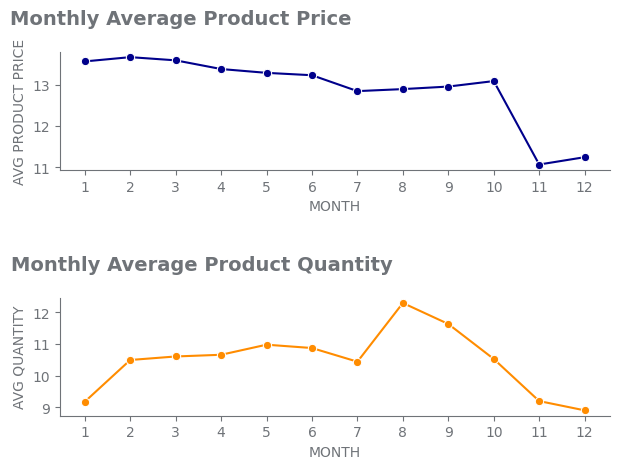

In [31]:
# Creating a list of required variable names
price_qty = ['Price', 'Quantity']

# Setting the figure and axes
fig, ax = plt.subplots(2, 1)

# Loop to create line plots for each variable
for i in range(len(price_qty)):    
    # For the plot of average monthly price
    if i == 0:
        sns.lineplot(x = 'Month', y = price_qty[i], data = success_df, 
                 ci = None, color = 'darkblue', marker = 'o', ax = ax[i])
        ax[i].set_title('Monthly Average Product Price', pad = 20, x = 0.22, 
                        size = 14, weight = 'bold', color = '#6F7378')
        ax[i].set_ylabel('AVG PRODUCT PRICE', color = '#6F7378')
    # For the plot of average monthly quantity
    else:
        sns.lineplot(x = 'Month', y = price_qty[i], data = success_df, 
                 ci = None, color = 'darkorange', marker = 'o', ax = ax[i])
        ax[i].set_title('Monthly Average Product Quantity', pad = 20, x = 0.258, 
                        size = 14, weight = 'bold', color = '#6F7378')
        ax[i].set_ylabel('AVG QUANTITY', color = '#6F7378')
    
    # Changing the x labels
    ax[i].set_xlabel('MONTH', color = '#6F7378')
    
    # Adjusting the x ticks
    ax[i].set_xticks(range(1, 13))
    
    # Changing the tick color
    ax[i].tick_params(color = '#6F7378') 
    
    # Changing the x and y tick labels colors
    plt.setp(ax[i].get_xticklabels(), color = '#6F7378') 
    plt.setp(ax[i].get_yticklabels(), color = '#6F7378') 
    
    # Changing the spines colors
    for spine in ax[i].spines.values():
        spine.set_edgecolor('#6F7378')
        
    # Removing the top and right spines
    sns.despine(right = True)

# Using tight layout to make the space even between plots
plt.tight_layout(h_pad = 3)

An examination of both plots reveals the underlying reasons behind the high transaction volume but lower total sales observed from September to December. During these months, customers' purchasing behavior shifts towards lower-priced products with smaller quantities. Further analysis in the future could delve into strategies for maintaining customer buying power and preventing sharp declines in revenue.

Having examined the monthly sales trend, let's now delve into the daily sales performance, categorized by `DayOfWeek`.

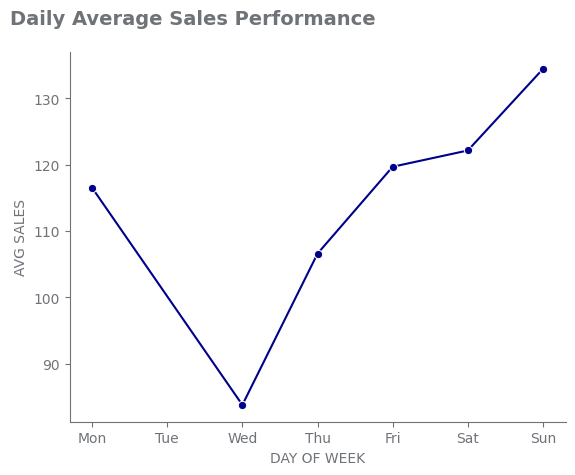

In [32]:
# Setting the figure and axes
fig, ax = plt.subplots()

# Plotting the daily sales performance
sns.lineplot(x = 'DayOfWeek', y = 'Revenue', data = success_df, ci = None, color = 'darkblue', marker = 'o', ax = ax)

# Removing the top and right spines
sns.despine(right = True)

# Changing the x ticks to display abbreviated day names
ax.set_xticks(range(0, 7), labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

# Changing the tick color
ax.tick_params(color = '#6F7378') 

# Changing the x and y tick labels colors
plt.setp(ax.get_xticklabels(), color = '#6F7378') 
plt.setp(ax.get_yticklabels(), color = '#6F7378') 

# Setting the label names of both axes
ax.set_xlabel('DAY OF WEEK', color = '#6F7378')
ax.set_ylabel('AVG SALES', color = '#6F7378')

# Changing the spines colors
for spine in ax.spines.values():
    spine.set_edgecolor('#6F7378')

# Adding plot title
ax.set_title('Daily Average Sales Performance', pad = 20, size = 14, x = -0.12, 
             weight = 'bold', color = '#6F7378', ha = 'left')

# Showing the plot
plt.show()

An analysis of daily sales performance reveals a notable uptrend towards the end of the week, with sales peaking on Sunday. Conversely, customer buying power appears weaker during midweek, from Tuesday to Wednesday. This behavior could be due to various factors, such as people being more focused on work or school during the week or having less leisure time to go shopping.

## Into the Countries
To gain an overview of the sales patterns across different countries, let's examine the sales distribution by country. First, we will aggregate the total `Revenue` by each country in this dataset and use a choropleth map to see the overall distribution of sales across countries.

In [33]:
# Aggregating sales by countries
country_sales = success_df.groupby(by = 'CountryISO3', as_index = False)['Revenue'].sum()

# Adding the country name back (instead of just ISO3)
country_sales['Country'] = [coco.convert(i, to = 'name_short') for i in country_sales['CountryISO3']]

# Plotting the choropleth map
fig = px.choropleth(country_sales, locations = 'CountryISO3',
                    color = 'Revenue',
                    color_continuous_scale = 'viridis',
                    hover_name = 'Country',
                    hover_data = {'CountryISO3':False},
                    title = 'Worldwide Sales Distributions')

# Showing the plot
fig.show()

Although the United Kingdom is the leading contributor to sales, generating over 52 million GBP, it is crucial to identify other countries that significantly impact sales performance. To better understand the sales landscape, we will focus on the top 10 contributing countries, as visualizing data for all 35 countries would make the plot too complex.

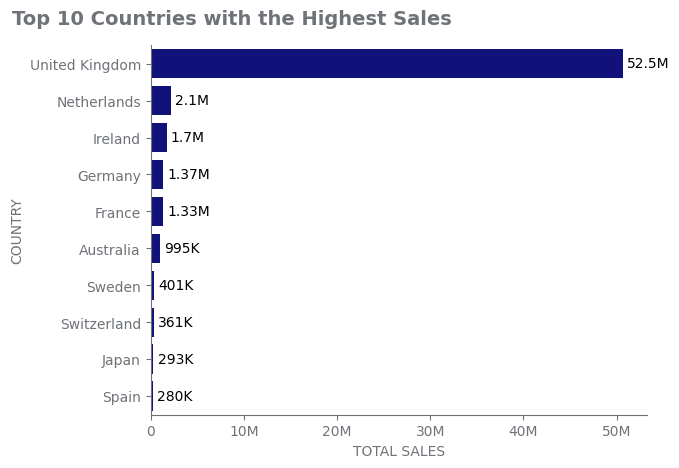

In [34]:
# Setting the figure and axes
fig, ax = plt.subplots()

# Plotting the top 10 country with most sales
sns.barplot(x = 'Revenue', y = 'Country', 
            data = country_sales.sort_values('Revenue', ascending = False).iloc[:10],
            color = 'darkblue', ax = ax)

# Removing top and right spines
sns.despine(right = True)

# Adding bar labels
ax.bar_label(ax.containers[0], labels = ['52.5M', '2.1M', '1.7M', '1.37M', '1.33M', 
                                         '995K', '401K', '361K', '293K', '280K'],
             padding = 3)

# Customizing the x ticks
ax.set_xticks(range(0, 55000000, 10000000), labels = ['0', '10M', '20M', '30M', '40M', '50M'])

# Changing the tick color
ax.tick_params(color = '#6F7378') 

# Changing the x and y tick labels colors
plt.setp(ax.get_xticklabels(), color = '#6F7378') 
plt.setp(ax.get_yticklabels(), color = '#6F7378') 

# Setting the label names of both axes
ax.set_xlabel('TOTAL SALES', color = '#6F7378')
ax.set_ylabel('COUNTRY', color = '#6F7378')

# Changing the spines colors
for spine in ax.spines.values():
    spine.set_edgecolor('#6F7378')

# Adding plot title
ax.set_title('Top 10 Countries with the Highest Sales', size = 14, x = -0.28, pad = 15,
             weight = 'bold', color = '#6F7378', ha = 'left')

# Showing the plot
plt.show()

The plot above reveals a distinct disparity between the United Kingdom and other countries. This disparity is unsurprising given that the e-commerce platform is based in the UK, naturally attracting a higher customer base. However, despite the UK's dominance, several other countries made notable contributions to overall sales:
- Netherlands: 2.1 million GBP
- Ireland: 1.7 million GBP
- Germany: 1.3 million GBP
- France: 1.3 million GBP
- Australia: 995,000 GBP

In addition to examining sales figures, we can further analyze customers' purchasing behavior by investigating the typical quantity of products purchased per transaction. By identifying the top 10 countries with the highest median order quantities, we can gain valuable insights into customer preferences based on their countries.

*Note: Because the `Quantity` column is right-skewed, we'll use the median as a better representation of the typical value*

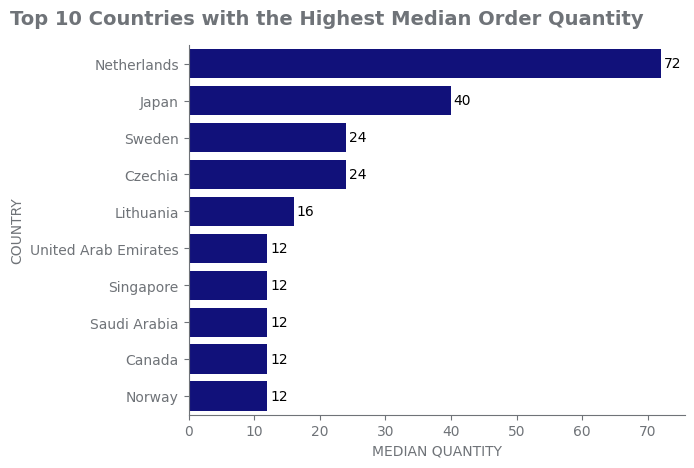

In [35]:
# Getting the typical order quantity by country
country_quantity = success_df.groupby('CountryISO3', as_index = False)['Quantity'].median()
country_quantity['Country'] = [coco.convert(country, to = 'name_short') for country in country_quantity['CountryISO3']]

# Setting the figure and axes
fig, ax = plt.subplots()

# Plotting the typical order quantity per country
sns.barplot(x = 'Quantity', y = 'Country', 
            data = country_quantity.sort_values('Quantity', ascending = False).iloc[:10],
            color = 'darkblue', ax = ax)

# Removing the top and right spines
sns.despine(right = True)

# Adding bar labels
ax.bar_label(ax.containers[0], padding = 2)

# Changing the tick color
ax.tick_params(color = '#6F7378') 

# Changing the x and y tick labels colors
plt.setp(ax.get_xticklabels(), color = '#6F7378') 
plt.setp(ax.get_yticklabels(), color = '#6F7378') 

# Setting the label names of both axes
ax.set_xlabel('MEDIAN QUANTITY', color = '#6F7378')
ax.set_ylabel('COUNTRY', color = '#6F7378')

# Changing the spines colors
for spine in ax.spines.values():
    spine.set_edgecolor('#6F7378')

# Adding plot title
ax.set_title('Top 10 Countries with the Highest Median Order Quantity', pad = 15, x = -0.36, size = 14,
             weight = 'bold', color = '#6F7378', ha = 'left')

# Showing the plot
plt.show()

Surprisingly, despite holding the top transaction count and sales figure, the United Kingdom does not rank among the top 10 countries with the highest median order quantity. Instead, the Netherlands emerges as the highest, with a median order quantity of 72 per transaction. This trend suggests that customers from countries outside the e-commerce platform's base location in the United Kingdom tend to place larger orders. This observation could imply that the products offered by the store possess unique characteristics (obviously made in the United Kingdom) that are particularly appealing to international buyers.

## Into the Products
First, let's determine the number of products this e-commerce store offers.

In [36]:
# Find the total number of products offered
print(f"Total product: {success_df['ProductName'].nunique()}")

Total product: 3752


With a vast product of 3,753 items, this e-commerce platform offers its customers a diverse range of options. To identify the most influential products driving sales, we will analyze the top 10 contributors to overall revenue.

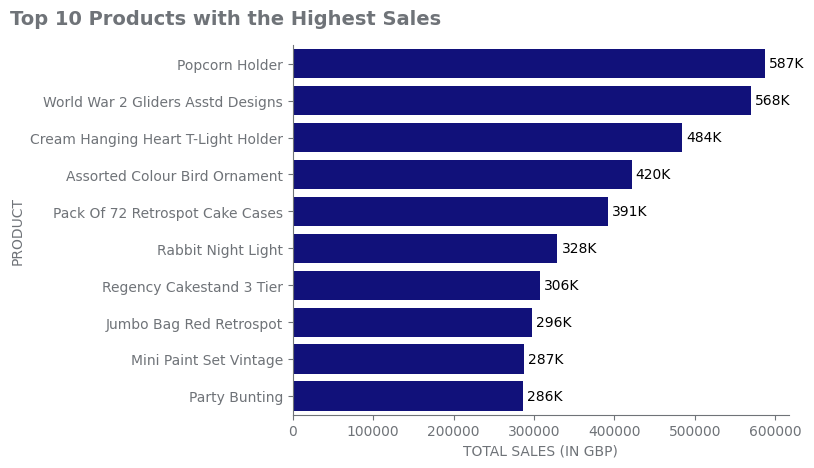

In [37]:
# Getting the total sales by product
product_sales = success_df.groupby('ProductName', as_index = False)['Revenue'].sum()

# Setting the figure and axes
fig, ax = plt.subplots()

# Plotting top 10 products with highest sales
sns.barplot(x = 'Revenue', y = 'ProductName',
            data = product_sales.sort_values('Revenue', ascending = False).iloc[:10],
            color = 'darkblue', ax = ax)

# Removing the top and right spines
sns.despine(right = True)

# Adding bar labels
ax.bar_label(ax.containers[0], labels = ['587K', '568K', '484K', '420K', '391K',
                                         '328K', '306K', '296K', '287K', '286K'],
             padding = 3)

# Changing the tick color
ax.tick_params(color = '#6F7378') 

# Changing the x and y tick labels colors
plt.setp(ax.get_xticklabels(), color = '#6F7378') 
plt.setp(ax.get_yticklabels(), color = '#6F7378') 

# Setting the label names of both axes
ax.set_xlabel('TOTAL SALES (IN GBP)', color = '#6F7378')
ax.set_ylabel('PRODUCT', color = '#6F7378')

# Changing the spines colors
for spine in ax.spines.values():
    spine.set_edgecolor('#6F7378')

# Adding plot title
ax.set_title('Top 10 Products with the Highest Sales', size = 14, x = -0.57, pad = 15,
             weight = 'bold', color = '#6F7378', ha = 'left')

# Showing the plot
plt.show()

The top 10 products with the highest total sales represent a diverse mix of household goods, decorative items, and toys, with Popcorn Holder being the top-selling product in the last 12 months. 

After examining the top 10 products by total sales, we focus on the top 10 products with the highest median order quantities to uncover any underlying trends in customer purchasing behavior.

*Note: Because the `Quantity` column is right-skewed, we're going to use the median as the better representation of the typical value*

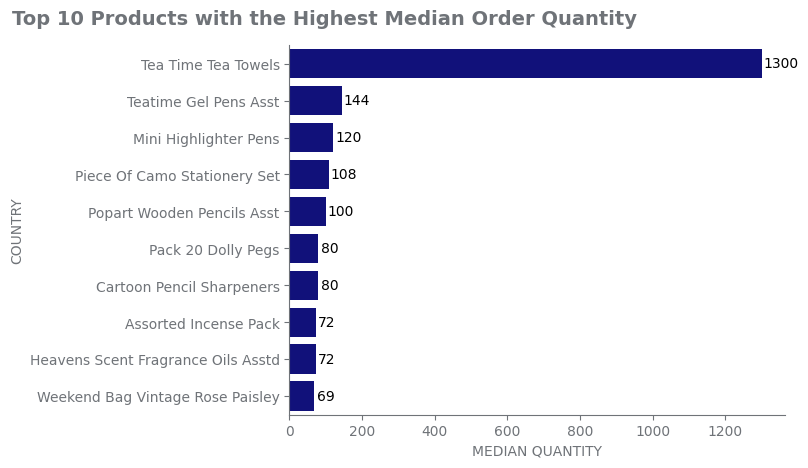

In [38]:
# Getting the median quantity by product
product_quantity = success_df.groupby('ProductName', as_index = False)['Quantity'].median()

# Setting the figure and axes
fig, ax = plt.subplots()

# Plotting top 10 product with highest median quantity
sns.barplot(x = 'Quantity', y = 'ProductName',
            data = product_quantity.sort_values('Quantity', ascending = False).iloc[:10],
            color = 'darkblue', ax = ax)

# Removing the top and right spines
sns.despine(right = True)

# Adding bar labels
ax.bar_label(ax.containers[0], padding = 1.5)

# Changing the tick color
ax.tick_params(color = '#6F7378') 

# Changing the x and y tick labels colors
plt.setp(ax.get_xticklabels(), color = '#6F7378') 
plt.setp(ax.get_yticklabels(), color = '#6F7378') 

# Setting the label names of both axes
ax.set_xlabel('MEDIAN QUANTITY', color = '#6F7378')
ax.set_ylabel('COUNTRY', color = '#6F7378')

# Changing the spines colors
for spine in ax.spines.values():
    spine.set_edgecolor('#6F7378')

# Adding plot title
ax.set_title('Top 10 Products with the Highest Median Order Quantity', size = 14, x = -0.56, pad = 15,
             weight = 'bold', color = '#6F7378', ha = 'left')

# Showing the plot
plt.show()

The 'Tea Time Tea Towels' product shows an exceptional median order quantity of 1300, far exceeding that of other products. This insight suggests a unique demand for this product, potentially driven by its association with the ingrained tea-time tradition in the United Kingdom, where most customers reside. This exceptional order quantity implies that customers purchase these tea towels in bulk, possibly for gift-giving or regular household use.

Meanwhile, stationery and writing tools consistently show high median order quantities, reflecting steady demand for these essential everyday items. This pattern aligns with their functional utility in various aspects of daily life, from education and professional settings to personal hobbies and creative activities. The frequent need for resupply and the diverse range of stationery products further contribute to their consistently high median order quantities.

# RFM: Preprocessing
## RFM Data: Preparation
The provided dataset requires preprocessing to facilitate RFM analysis, which utilizes three key metrics: Recency, Frequency, and Monetary value. The current dataset is long data, where one customer's observations (particularly `CustomerNo`) can appear more than once in the rows. We'll group the data by each customer's `CustomerNo` to prepare it. This operation will enable us to calculate the following for each customer:

- Recency: We'll determine the recency by subtracting the `Date` from the analysis date, assuming the analysis is conducted one day after the latest recorded transaction date.

- Frequency: For each customer, we'll calculate the frequency metric by counting the unique TransactionNo occurrences in their records, indicating the total number of distinct transactions made.

- Monetary: We'll aggregate each customer's total money spent from the `Revenue` column.

In [39]:
# Getting the max Date, nunique of TransactionNo, and sum of Revenue per customer 
rfm_df = success_df.groupby('CustomerNo', as_index = False)[['Revenue', 'TransactionNo', 'Date']]\
                   .agg({'Date' : 'max',
                         'TransactionNo' : 'nunique',
                         'Revenue' : 'sum',})

# Renaming the columns
rfm_df.columns = ['CustomerNo', 'Recency', 'Frequency', 'Monetary']

# Converting the Recency column that contains max date to a datetime
rfm_df['Recency'] = pd.to_datetime(rfm_df['Recency'])

# Initializing 'date' variable that contains the analysis date
date = pd.to_datetime('2019-12-10')

# Subtracting max date from analysis date
rfm_df['Recency'] = date - rfm_df['Recency']

# Getting the days
rfm_df['Recency'] = rfm_df['Recency'].dt.days

# Checking the result
rfm_df

,CustomerNo,Recency,Frequency,Monetary
0,12004,228,1,1509.60
1,12006,219,1,24.76
2,12008,277,1,5689.57
3,12013,360,1,69.96
4,12024,177,1,149.52
...,...,...,...,...
4712,18280,278,1,623.26
4713,18281,181,1,576.58
4714,18282,8,2,1044.86
4715,18283,4,16,12114.61


Based on this data, there are a total of 4,717 recorded customers.

## RFM Data: Quick Exploration
Before preprocessing the variables in the RFM data, let's quickly explore the variables to identify outliers, skewness, and central tendencies for each variable. 

In [40]:
# Statistical summary of RFM data
rfm_df.describe(exclude = 'object').round(2)

,Recency,Frequency,Monetary
count,4717.00,4717.00,4717.00
mean,96.99,4.19,12958.04
std,101.72,7.40,51059.60
min,1.00,1.00,5.97
25%,19.00,1.00,1834.58
50%,54.00,2.00,4817.56
75%,157.00,5.00,11890.55
max,374.00,207.00,2112282.03


There are some interesting insights to take note here:
1. **Outliers:** The `Frequency` and `Monetary` columns show extreme outliers, with values of 207 transactions and 2,112,282 GBP, respectively. The `Recency` variable also indicates a potential outlier of 374 days. These outliers require careful handling to ensure they don't negatively influence the clustering process.
2. **Data Dispersion:** Across all RFM variables, the standard deviation exceeds the mean, indicating a wider spread of data points around the average value, suggesting that the data is more dispersed and less concentrated.
3. **Right Skewness:** All RFM variables display right-skewed distributions, with means higher than medians. This skewness could be mitigated by addressing the outliers identified earlier.

Next, let's investigate the distribution of all the RFM variables using box plots.

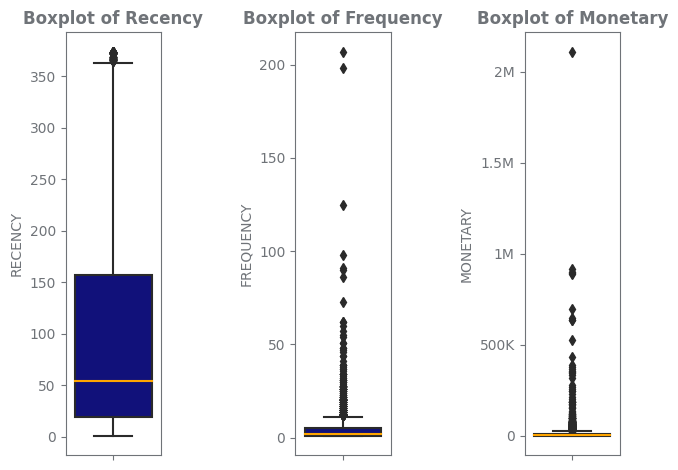

In [41]:
# Getting the RFM variables to plot
cols = rfm_df.columns[1:]

# Setting the figure and axes
fig, ax = plt.subplots(1, 3)

# Creating box plots
for col in range(len(cols)):

    # Creating the box plot
    sns.boxplot(y = cols[col], data = rfm_df, color = 'darkblue', 
                medianprops = {'color' : 'orange'}, ax = ax[col])
    
    # For the 'Monetary' box plot
    if cols[col] == 'Monetary':
        # Make the yticks more readable
        ax[col].set_yticks(range(0, 2500000, 500000), labels = ['0', '500K', '1M', '1.5M', '2M'])
        
    # Customizing the y label
    ax[col].set_ylabel(cols[col].upper(), color = '#6F7378')
    
    # Changing the tick color
    ax[col].tick_params(color = '#6F7378') 
    
    # Changing the x and y tick labels colors
    plt.setp(ax[col].get_xticklabels(), color = '#6F7378') 
    plt.setp(ax[col].get_yticklabels(), color = '#6F7378') 
    
    # Changing the spines colors
    for spine in ax[col].spines.values():
        spine.set_edgecolor('#6F7378')
        
    # Adding the plot title
    ax[col].set_title(f'Boxplot of {cols[col]}', weight = 'bold', color = '#6F7378')    
        
# Showing the figure with a tight layout
plt.tight_layout(w_pad = 5)

There are some interesting observations here:
- **`Recency`:** The `Recency` variable shows a few collective outliers but (thankfully) lacks extreme outliers, suggesting that the distribution of recency values is relatively well-behaved, with no extreme outliers significantly impacting the overall data pattern.
- **`Frequency` and `Monetary`:** In contrast, the `Frequency` and `Monetary` variables show several global outliers that likely skew their distributions towards higher values (right skewness). These outliers deserve priority attention during the outlier handling process to ensure they don't negatively influence the analysis.

To further confirm our initial assessment of the distributional shapes of the RFM variables, let's dig deeper into their characteristics using histograms and skewness measures.

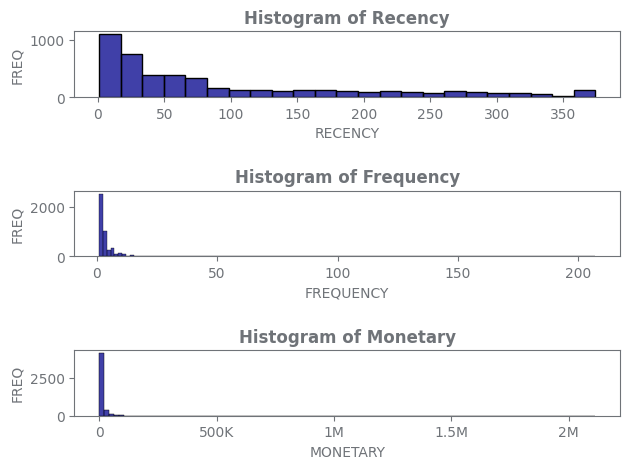

In [42]:
# Setting the figure and axes
fig, ax = plt.subplots(3, 1)

# Loop to create histograms across RFM variables
for col in range(len(cols)):
    
    # For the 'Frequency' histogram
    if cols[col] == 'Frequency':
        sns.histplot(x = cols[col], data = rfm_df, color = 'darkblue', bins = 130, ax = ax[col])
        
    # For the 'Monetary' histogram
    elif cols[col] == 'Monetary':
        sns.histplot(x = cols[col], data = rfm_df, color = 'darkblue', bins = 100, ax = ax[col])
        ax[col].set_xticks(range(0, 2500000, 500000), labels = ['0', '500K', '1M', '1.5M', '2M']) # Make the xticks more readable
        
    # For the 'Recency' histogram
    else:
        sns.histplot(x = cols[col], data = rfm_df, color = 'darkblue', ax = ax[col])
    
    # Customizing the y label
    ax[col].set_ylabel('FREQ', color = '#6F7378')
    ax[col].set_xlabel(cols[col].upper(), color = '#6F7378')
    
    # Changing the tick color
    ax[col].tick_params(color = '#6F7378') 
    
    # Changing the x and y tick labels colors
    plt.setp(ax[col].get_xticklabels(), color = '#6F7378') 
    plt.setp(ax[col].get_yticklabels(), color = '#6F7378') 
    
    # Changing the spines colors
    for spine in ax[col].spines.values():
        spine.set_edgecolor('#6F7378')
    
    # Adding plot title
    ax[col].set_title(f'Histogram of {cols[col]}', weight = 'bold', color = '#6F7378')

# Showing the figure with a tight layout
plt.tight_layout(h_pad = 2)

In [43]:
# Skewness measure
print(f'Skewness measurements: \n{rfm_df.skew(numeric_only = True)}')

Skewness measurements: 
Recency       1.161303
Frequency    12.231223
Monetary     22.051578
dtype: float64


This analysis confirms our initial assumptions that all of the RFM variables are right-skewed, with `Frequency` and `Monetary` exhibiting high degrees of skewness. Global outliers in these variables' values likely contribute to this extreme skewness.

## Outliers Handling
To ensure accurate results from the clustering algorithm, we must first address the presence of outliers, especially for k-means that are susceptible to their influence. This process will involve identifying and removing or adjusting outliers to minimize their impact on clustering.

We will use the IQR method to handle the remaining outliers to ensure an accurate and better representation of clusters.

In [44]:
# Getting and printing the total rows before outlier handling
original_data = len(rfm_df)
print(f'Rows before outlier handling (z-score): {original_data}')

# Creating the filter mask
filtered_entries = np.array([True] * len(rfm_df))

# IQR filtering
for i in cols:
    q1 = rfm_df[i].quantile(0.25)
    q3 = rfm_df[i].quantile(0.75)
    iqr = q3 - q1
    low_limit = q1 - (1.5 * iqr)
    high_limit = q3 + (1.5 * iqr)
    filtered_entries = ((rfm_df[i] >= low_limit) & (rfm_df[i] <= high_limit)) & filtered_entries

# Filtering the original data from outliers
rfm_df = rfm_df[filtered_entries]

# Getting and printing the total rows after outlier handling
new_data = len(rfm_df)
print(f'Rows before outlier handling (z-score): {len(rfm_df)}')
print(f'Data loss: {round((original_data - new_data) / new_data * 100, 2)}%')

Rows before outlier handling (z-score): 4717
Rows before outlier handling (z-score): 4154
Data loss: 13.55%


After the outlier removal using the IQR method, we experienced a data loss of approximately 13.6%. Let's now visualize the distribution of the processed data using box plots to assess the effectiveness of outlier handling.

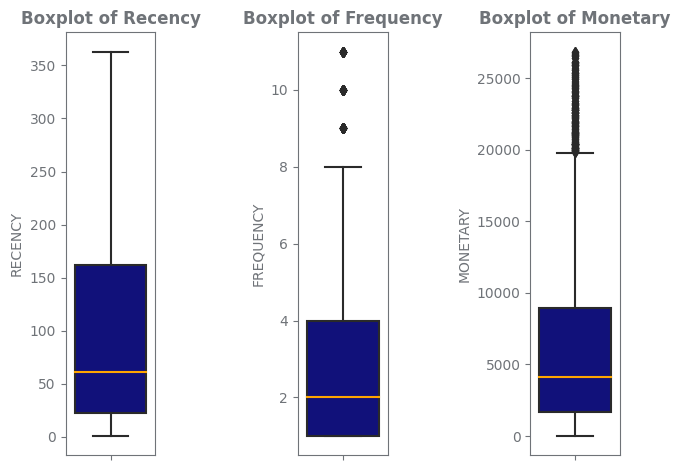

In [45]:
# Getting the RFM variables to plot
cols = rfm_df.columns[1:]

# Setting the figure and axes
fig, ax = plt.subplots(1, 3)

# Creating box plots
for col in range(len(cols)):
    
    # Creating the box plot
    sns.boxplot(y = cols[col], data = rfm_df, color = 'darkblue', 
                medianprops = {'color' : 'orange'}, ax = ax[col])
        
    # Customizing the y label
    ax[col].set_ylabel(cols[col].upper(), color = '#6F7378')
    
    # Changing the tick color
    ax[col].tick_params(color = '#6F7378') 
    
    # Changing the x and y tick labels colors
    plt.setp(ax[col].get_xticklabels(), color = '#6F7378') 
    plt.setp(ax[col].get_yticklabels(), color = '#6F7378') 
    
    # Changing the spines colors
    for spine in ax[col].spines.values():
        spine.set_edgecolor('#6F7378')
        
    # Adding the plot title
    ax[col].set_title(f'Boxplot of {cols[col]}', weight = 'bold', color = '#6F7378')    
        
# Showing the figure with a tight layout
plt.tight_layout(w_pad = 5)

Now, our distribution of `Frequency` and `Monetary` are cleaner and better represent the central tendency of the data. While a few outliers remain, their presence is considered acceptable due to their moderate values (not too extreme) and their reflection of the diverse purchasing behavior of customers. Despite being identified as outliers, these customers represent valid transactions and contribute meaningfully to the e-commerce landscape.

## Scaling
Since clustering algorithms rely on distance calculations to assess the similarity between data points, data scaling is vital to ensure accurate and meaningful clustering results. Scaling normalizes the data, preventing variables with more extensive ranges, such as `Monetary` in this case, from excessively influencing the distance calculations. This technique ensures that all variables contribute equally to the clustering process, leading to a more balanced and representative outcome.

We are going to use `StandardScaler()` here.

In [46]:
# Initializing the scaler object with Pandas DataFrame output
scaler = StandardScaler().set_output(transform = 'pandas')

# Fitting the RobustScaler to RFM data (Excluding the CustomerNo)
scaler.fit(rfm_df.iloc[:, 1:])

# Transform the RFM data to be robust-scaled (Excluding the CustomerNo)
rfm_df_std = scaler.transform(rfm_df.iloc[:, 1:])

# Checking the output
rfm_df_std

,Recency,Frequency,Monetary
0,1.317194,-0.839731,-0.792759
1,1.224658,-0.839731,-1.042841
2,1.821002,-0.839731,-0.088752
3,2.674390,-0.839731,-1.035228
4,0.792823,-0.839731,-1.021828
...,...,...,...
4711,-0.266200,-0.839731,-0.903073
4712,1.831283,-0.839731,-0.942039
4713,0.833951,-0.839731,-0.949901
4714,-0.944798,-0.383334,-0.871032


# RFM: Dimensionality Reduction (PCA)
We'll apply PCA here to enhance k-means performance by reducing redundancy and focusing on informative variables. This method minimizes the impact of multicollinearity, especially in RFM variables known for high multicollinearity. PCA also facilitates cluster visualization with 2D scatter plots instead of 3D, simplifying cluster understanding.

With only three variables, two principal components effectively capture most of the explained variance.

In [47]:
# Initializing the PCA object with 2 components
pca = PCA(n_components = 2)

# Fitting the PCA to the scaled rfm dataset
pca.fit(rfm_df_std)

# Transforming the scaled rfm dataset to PCA 
pca_df = pd.DataFrame(pca.transform(rfm_df_std), columns = ['pc1', 'pc2'])

# Ensuring that the index is the same with the original rfm dataset
pca_df.set_index(rfm_df.index, inplace = True)

# Showing the output
pca_df

,pc1,pc2
0,-1.651068,0.577214
1,-1.756382,0.383149
2,-1.473448,1.332578
3,-2.459935,1.632246
4,-1.532801,0.021742
...,...,...
4711,-0.944037,-0.833771
4712,-1.992026,0.950537
4713,-1.509601,0.090027
4714,-0.304932,-1.298134


# RFM: Clustering with k-means
To begin the clustering process, we must determine the optimal number of clusters represented by 'k.' We'll start by examining the Sum of Squared Errors (SSE), also known as Inertia and the silhouette coefficient for values of 'k' ranging from 2 to 10.

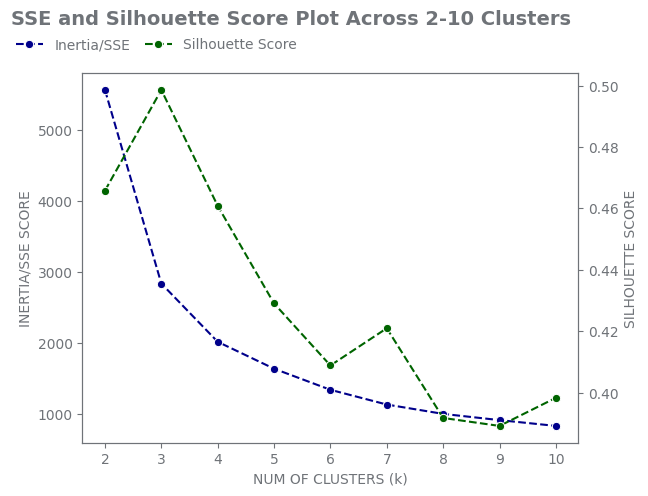

In [48]:
# Empty variables to be filled with sse (inertia) and silhouette scores
sse = []
silhouette = []

# Getting the sse and silhouette scores for k = 2 to k = 10
for k in range(2, 11):
    kmeans = KMeans(n_clusters = k, random_state = 10).fit(pca_df)
    sse.append(kmeans.inertia_)
    cluster_label = kmeans.labels_
    silhouette.append(silhouette_score(pca_df, cluster_label))
    
# Plot of sse (inertia) and silhouette metrics
fig, ax = plt.subplots()

# Creating the lineplot for SSE Scores
sns.lineplot(x = range(2, 11), y = sse, marker = 'o', linestyle = '--', color = 'darkblue',
             label = 'Inertia/SSE', ax = ax)

# Adding secondary y axis for the Silhouette Score
ax2 = ax.twinx()

# Creating the lineplot for Silhouette Score
sns.lineplot(x = range(2, 11), y = silhouette, marker = 'o', linestyle = '--', color = 'darkgreen',
             label = 'Silhouette Score', ax = ax2)

# Adding x and y labels
ax.set_xlabel('NUM OF CLUSTERS (k)', color = '#6F7378')
ax.set_ylabel('INERTIA/SSE SCORE', color = '#6F7378')
ax2.set_ylabel('SILHOUETTE SCORE', color = '#6F7378')

# Adding legends
ax.legend(loc = 2, frameon = False, bbox_to_anchor = [-0.16, 1.13], labelcolor = '#6F7378')
ax2.legend(loc = 2, frameon = False, bbox_to_anchor = [0.1, 1.13], labelcolor = '#6F7378')

# Adding title
ax2.set_title('SSE and Silhouette Score Plot Across 2-10 Clusters', size = 14, pad = 35, 
              x = 0.42, weight = 'bold', color = '#6F7378')

# Changing the tick color
ax.tick_params(color = '#6F7378') 
ax2.tick_params(color = '#6F7378') 

# Changing the x and y tick labels colors
plt.setp(ax.get_xticklabels(), color = '#6F7378') 
plt.setp(ax.get_yticklabels(), color = '#6F7378') 
plt.setp(ax2.get_xticklabels(), color = '#6F7378') 
plt.setp(ax2.get_yticklabels(), color = '#6F7378') 

# Changing the spines colors
for spine in ax.spines.values():
    spine.set_edgecolor('#6F7378')
for spine in ax2.spines.values():
    spine.set_edgecolor('#6F7378')

# Showing the plot
plt.show()

We can see that the optimal value for k is 3, which has the highest silhouette score and is located in the 'elbow' part of the SSE plot. We can further check with the silhouette plot.

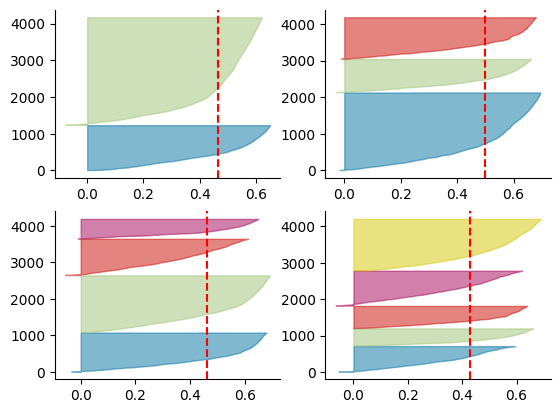

In [49]:
# Setting the figure and axes
fig, ax = plt.subplots(2, 2)

# Loop to create silhouette plots for each benchmarked 'k' values
for k in range(2, 6):
    km = KMeans(n_clusters = k, random_state = 10)
    q, mod = divmod(k, 2)
    visualizer = SilhouetteVisualizer(km, colors = 'yellowbrick', ax = ax[q-1][mod])
    visualizer.fit(pca_df)
    
# Removing the top and right spines
sns.despine(right = True)

# Showing the figure with a tight layout
plt.show()

All these k values show imbalanced cluster proportions, but k = 3 appears less imbalanced than the others. Moreover, k = 3 shows the least negative silhouette scores across each cluster. 

Let's apply `k` equals 3 in the clustering process and get the cluster labels.

In [50]:
# K-means clustering with k = 3
km = KMeans(n_clusters = 3, random_state = 10)
km.fit(pca_df)

# Assigning the cluster label to the PCA data to be visualized
pca_df['Cluster'] = km.labels_

## Cluster Analysis
Now, let's see the cluster visualization using the PCA data.

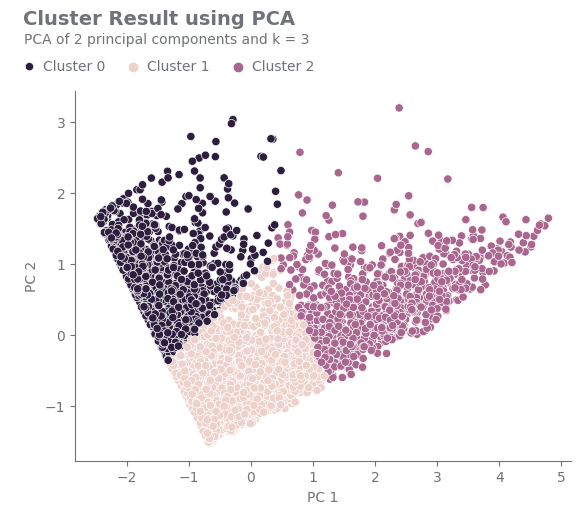

In [51]:
# Setting the figure and axes
fig, ax = plt.subplots()

# Using scatter plot to see the formed clusters
sns.scatterplot(x = 'pc1', y = 'pc2', hue = 'Cluster', data = pca_df, ax = ax)

# Removing the top and right spines
sns.despine(right = True)

# Changing the tick color
ax.tick_params(color = '#6F7378') 

# Changing the x and y tick labels colors
plt.setp(ax.get_xticklabels(), color = '#6F7378') 
plt.setp(ax.get_yticklabels(), color = '#6F7378') 

# Setting the label names of both axes
ax.set_xlabel('PC 1', color = '#6F7378')
ax.set_ylabel('PC 2', color = '#6F7378')

# Changing the spines colors
for spine in ax.spines.values():
    spine.set_edgecolor('#6F7378')

# Adding plot title and subtitle
ax.set_title('Cluster Result using PCA', size = 14, x = 0.17,
             pad = 48, color = '#6F7378', weight = 'bold')
ax.text(-3.65, 4.1, 'PCA of 2 principal components and k = 3', color = '#6F7378')

# Customizing the legends
ax.legend(loc = 2, ncol = 3, frameon = False, bbox_to_anchor = [-0.145, 1.12],
          labels = ['Cluster ' + str(i) for i in sorted(pca_df['Cluster'].unique())],
          handletextpad = 0, columnspacing = 1, labelcolor = '#6F7378')

# Showing the plot
plt.show()

From the visualization, we observe an acceptable separation between clusters, acknowledging a few instances where clusters appear to belong to either group. Despite this, the overall shape indicates that our clustering process has yielded decent clusters.

Next, we'll compare the RFM statistical summaries of the identified clusters. Considering the skewed distribution of the initial data, we'll choose the median over the mean as the measure of central tendency for each RFM variable. We'll also assign the cluster column produced from the PCA data to the original RFM data.

In [52]:
# Assigning produced clusters from the PCA data to the RFM data
rfm_df['Cluster'] = pca_df['Cluster']

# Grouping by cluster and aggregating the min, max, and median of RFM variables
rfm_df.groupby('Cluster').agg({'Recency' : ['mean', 'median', 'min', 'max'],
                               'Frequency' : ['mean', 'median', 'min', 'max'],
                               'Monetary' : ['mean', 'median', 'min', 'max']})

Recency                  Frequency                     Monetary  \
               mean median  min  max      mean median min max          mean   
Cluster                                                                       
0         51.144880   43.0    1  173  2.236904    2.0   1   7   4258.441505   
1         39.603753   25.0    1  265  5.994481    6.0   1  11  14903.661402   
2        239.759079  239.0  134  363  1.440213    1.0   1   6   2920.369522   

                                       
            median      min       max  
Cluster                                
0         3509.620     5.97  17016.46  
1        14589.185  1657.98  26875.24  
2         1846.660    11.53  21255.40

Based on the summary statistics of the identified clusters, we can tentatively label each cluster as follows:
- Cluster 0: **Occasional Customers** (Moderate R, F, and M)
- Cluster 1: **Loyal Customers** (Lowest R, Highest F and M)
- Cluster 2: **At-Risk Customers** (Highest R, Lowest F and M)


To easily compare the cluster groups, let's create a visualization showing each cluster's distributions and central tendencies of `Recency`, `Frequency`, and `Monetary`. We'll start with the boxplot to see the distribution of each variable first based on clusters.

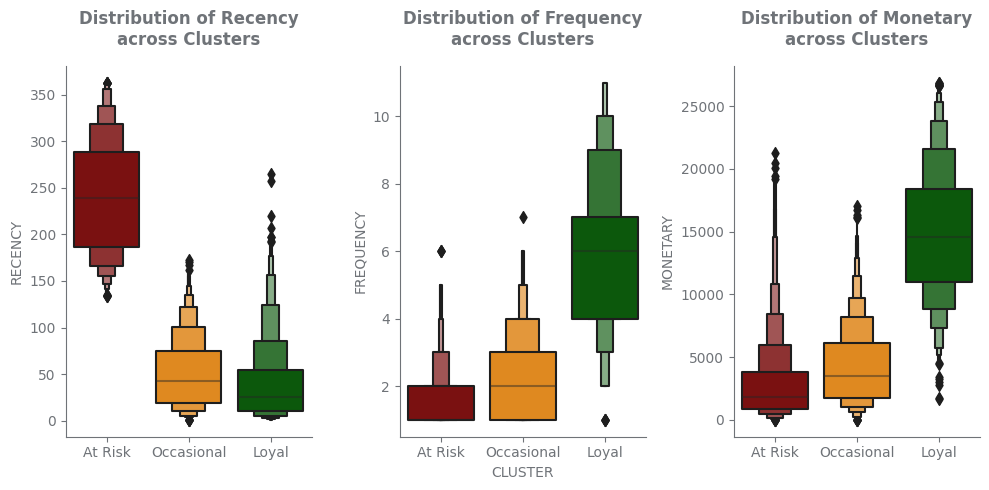

In [53]:
# Adding the ClusterName feature
cluster_map = {0 : 'Occasional', 
               1 : 'Loyal', 
               2 : 'At Risk'}

# Creating a variable 'ClusterName' that contains the name of each cluster
rfm_df['ClusterName'] = rfm_df['Cluster'].map(cluster_map)

# Getting the RFM variable names
cols = rfm_df.columns.tolist()[1:4] 

# Box plot of each cluster that compares the median of RFM variables
fig, ax = plt.subplots(1, 3, figsize = (10, 5))
for i in range(len(cols)):
    sns.boxenplot(x = rfm_df['ClusterName'], y = rfm_df[cols[i]],
                  palette = ['darkred', 'darkorange', 'darkgreen'], ax = ax[i])
    
    # Adding plot titles
    ax[i].set_title(f'Distribution of {cols[i]}\nacross Clusters', pad = 15, color = '#6F7378', weight = 'bold')
    
    # Setting different x and y labels for each plot
    if i == 0:
        ax[i].set_ylabel('RECENCY', color = '#6F7378')
        ax[i].set_xlabel('')
    elif i == 1:
        ax[i].set_ylabel('FREQUENCY', color = '#6F7378')
        ax[i].set_xlabel('CLUSTER', color = '#6F7378')
    else:
        ax[i].set_ylabel('MONETARY', color = '#6F7378')
        ax[i].set_xlabel('')
        
    # Changing the tick color
    ax[i].tick_params(color = '#6F7378') 
    
    # Changing the x and y tick labels colors
    plt.setp(ax[i].get_xticklabels(), color = '#6F7378') 
    plt.setp(ax[i].get_yticklabels(), color = '#6F7378') 
    
    # Changing the spines colors
    for spine in ax[i].spines.values():
        spine.set_edgecolor('#6F7378')
    
    # Removing the top and right spines
    sns.despine(right = True)
    
    # Removing the grids
    ax[i].grid(False)
    
plt.tight_layout()

Then, we'll use bar plots to see each variable's central tendency, using the median as our estimator.

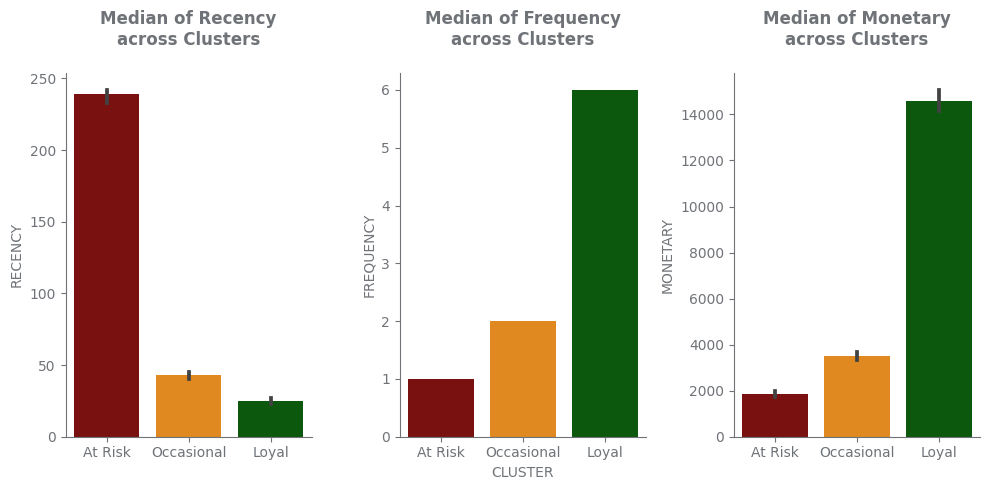

In [54]:
# Setting the figure and axes
fig, ax = plt.subplots(1, 3, figsize = (10, 5))

# Create bar plots for each RFM variables
for i in range(len(cols)):
    sns.barplot(x = rfm_df['ClusterName'], y = rfm_df[cols[i]], estimator = 'median',
                    palette = ['darkred', 'darkorange', 'darkgreen'], ax = ax[i])
    
    # Setting each plot's title
    ax[i].set_title(f'Median of {cols[i]}\nacross Clusters', pad = 20, color = '#6F7378', weight = 'bold')
    
    # Setting different x and y labels for each plot
    if i == 0:
        ax[i].set_ylabel('RECENCY', color = '#6F7378')
        ax[i].set_xlabel('')
    elif i == 1:
        ax[i].set_ylabel('FREQUENCY', color = '#6F7378')
        ax[i].set_xlabel('CLUSTER', color = '#6F7378')
    else:
        ax[i].set_ylabel('MONETARY', color = '#6F7378')
        ax[i].set_xlabel('')
        
    # Changing the tick color
    ax[i].tick_params(color = '#6F7378') 
    
    # Changing the x and y tick labels colors
    plt.setp(ax[i].get_xticklabels(), color = '#6F7378') 
    plt.setp(ax[i].get_yticklabels(), color = '#6F7378') 
    
    # Changing the spines colors
    for spine in ax[i].spines.values():
        spine.set_edgecolor('#6F7378')
        
    # Removing the top and right spines
    sns.despine(right = True)
    
    # Removing the grids
    ax[i].grid(False)
    
plt.tight_layout()

From these bar and box plots, we can formulate each cluster's characteristics:
1. **AT-RISK CUSTOMERS**
    - High recency: 
        - At-risk customers have not made a recent purchase on the e-commerce platform, with a median of 239 days since their last order as of this analysis. 
        - The spread of recency is wider than other clusters (IQR = 102 days), where customers typically have around 186-288 days since their last order as of this analysis.
        - This indicates a potential loss of interest in the e-commerce platform or a shift towards alternative options.
    - Low frequency: 
        - At-risk customers show infrequent purchasing behavior, with a median of only one purchase to date. 
        - The frequency spread is tighter than other clusters (IQR = 1 transaction), where customers typically transact 1-2 times to date.
        - This suggests that they may not find the products or services they need on the platform or are drawn to competitors offering better products, deals, or discounts.
    - Low monetary: 
        - At-risk customers tend to make relatively small purchases when they engage with the platform, with a median spending of 1,846 GBP. 
        - The monetary spread is tighter than other clusters (IQR = £2,935), where customers typically spend around £885-£3,820 to date in total.
        - This suggests that they may not perceive the products as high-value additions or have budget constraints limiting their spending.
2. **OCCASIONAL CUSTOMERS**
    - Moderate recency: 
        - Occasional customers have made purchases or interacted with the e-commerce platform moderately recently, with a median of 43 days since their last order as of this analysis.
        - The spread of recency is slightly wider than the Loyal Customers cluster but tighter than the At-Risk Customers cluster (IQR = 56 days), where customers typically have around 19-75 days since their last order as of this analysis.
        - This indicates they are still aware of the brand and may be open to future engagement.
        - However, they may not be as actively engaged as customers with higher recency scores, suggesting a need for targeted marketing efforts to maintain their interest.
    - Moderate frequency: 
        - Occasional customers show moderate purchasing behavior on e-commerce, with a median of 2 purchases to date. 
        - The spread of frequency is slightly wider than the At-Risk Customers cluster but tighter than the Loyal Customers cluster (IQR = 2 transactions), where customers typically transact 1-3 times to date
        - This suggests that they are interested in the products offered but may not be habitual customers. 
        - They may be responsive to price promotions, e-commerce innovations, or personalized marketing campaigns to increase purchase frequency.
    - Moderate monetary: 
        - Occasional customers spend moderate amounts when they place orders, with a median spending of 3,509 EUR to date. 
        - The monetary spread is wider than the At Risk Customers cluster but tighter than the Loyal Customers cluster (IQR = £4,397), where customers typically spend around £1,764-£6,161 to date in total.
        - This suggests they see some value in e-commerce products but may view them as something other than their primary choice. 
        - They may have other competing e-commerce options or are price-conscious, presenting an opportunity to give them exclusive offers or personalized recommendations.
3. **LOYAL CUSTOMERS**
    - Low recency:
        - Loyal customers have made orders in the e-commerce very recently, with a median of 25 days since their last order as of this analysis.
        - The spread of recency is tighter than other clusters (IQR = 44 days), where customers typically have around 10-54 days since their last order as of this analysis.
        - This indicates that they are actively engaged with the platform and likely continue doing so.
        - They may be the people who are mostly responsive to new products, seasonal promotions, and new innovations in the e-commerce platform.
    - High frequency
        - Loyal customers frequently made orders, with a median of 6 orders to date.
        - The frequency spread is wider than other clusters (IQR = 3 transactions), where customers typically transact 4-7 times to date.
        - This suggests that they are a habitual customer relying on e-commerce products.
        - Because of this, they may be susceptible to price changes or product availability.
    - High monetary
        - Loyal customers spend large amounts when they order, with a median spending of 14,589 EUR to date.
        - The monetary spread is wider than other clusters (IQR = £7,447), where customers typically spend around £10,956-£18,404 to date.
        - This indicates that they see high value in the e-commerce products and are willing to pay high prices.
        - They may be more likely to consider upgrades and additional services.

Based on the clusters' characteristics above, the **Loyal Customers cluster ** is our potential cluster to target. Next, let's investigate the proportion of clusters in our data.

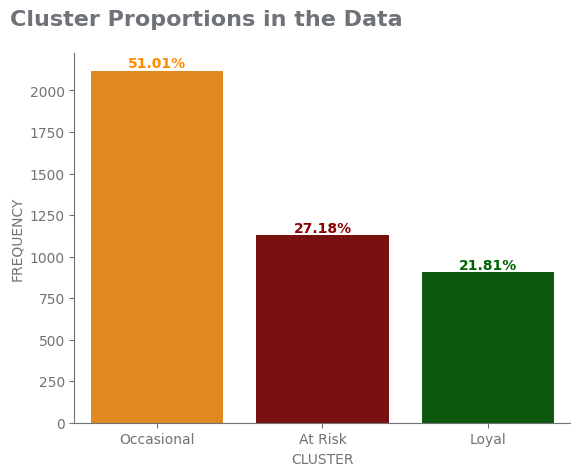

In [55]:
# Finding each cluster's proportion and frequency and store it into a dataset
cluster_size = rfm_df['ClusterName'].value_counts().to_frame().reset_index()
cluster_size['prop'] = round((cluster_size['count'] / cluster_size['count'].sum()) * 100, 2)

# Setting the figure and axes
fig, ax = plt.subplots()

# Creating the bar plot
sns.barplot(x = 'ClusterName', y = 'count', data = cluster_size, 
            palette = ['darkorange', 'darkred', 'darkgreen'], ax = ax)

# Removing the top and right spines
sns.despine(right = True)

# Adding bar labels that represents proportion (%)
bl = ax.bar_label(ax.containers[0], labels = [str(x) + '%' for x in cluster_size['prop'].tolist()],
                  weight = 'bold')

# Changing individual bar label colors
bl[0].set_color('darkorange')
bl[1].set_color('darkred')
bl[2].set_color('darkgreen')

# Changing the tick color
ax.tick_params(color = '#6F7378') 

# Changing the x and y tick labels colors
plt.setp(ax.get_xticklabels(), color = '#6F7378') 
plt.setp(ax.get_yticklabels(), color = '#6F7378') 

# Setting the label names of both axes
ax.set_xlabel('CLUSTER', color = '#6F7378')
ax.set_ylabel('FREQUENCY', color = '#6F7378')

# Changing the spines colors
for spine in ax.spines.values():
    spine.set_edgecolor('#6F7378')

# Setting title and subtitle
ax.set_title('Cluster Proportions in the Data', weight = 'bold', size = 16, 
             x = -0.13, pad = 20, ha = 'left', color = '#6F7378')
    
# Showing the plot
plt.show()

In summary, our customer base is mainly composed of Occasional Customers (2119 individuals), followed by At-Risk Customers (1129 individuals), with the smallest portion being Loyal Customers (only 906 individuals). This insight raises concerns as the number of customers genuinely engaged with our e-commerce and its products is lower than those who make occasional purchases or even those at-risk customers who rarely transact.

## Loyal Customers Cluster Analysis
For now, let's focus on the Loyal Customers cluster because even though they're small in numbers, they're still our most potential customer segment. Next, let's inspect their other characteristics, such as:
1. Most purchased products
2. Typical purchase quantity and 
3. Typical prices of the products purchased
4. Typical period of purchase (Day of Week and Month)

In [56]:
# Merging (inner join) the RFM dataframe with the original dataframe
final_df = success_df.merge(rfm_df, on = 'CustomerNo')

# Focusing on Loyal Customers only
loyal_df = final_df[final_df['ClusterName'] == 'Loyal']

### Most Purchased Products
To identify the most popular products, we'll calculate the total number of purchases and highlight the top 10 products with the highest purchase frequency.

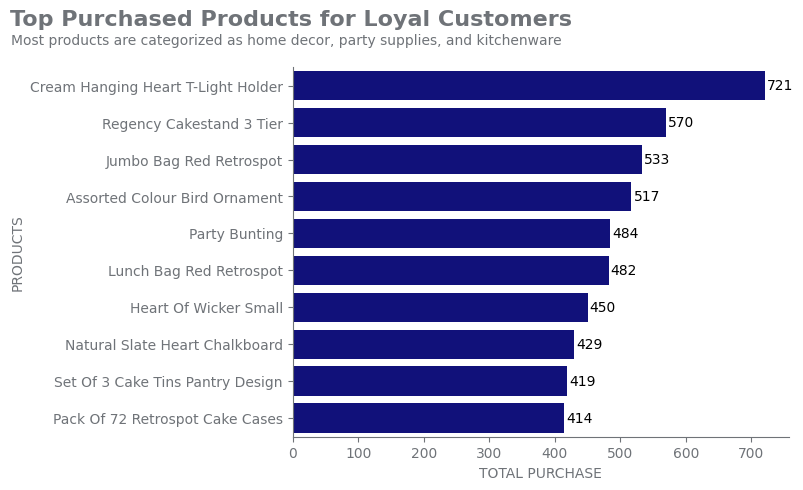

In [57]:
# Getting the top 10 favorite products for loyal customers
top_products = loyal_df['ProductName']\
               .value_counts()\
               .to_frame(name = 'Frequency')\
               .reset_index()\
               .iloc[:10]

# Setting the figure and axes
fig, ax = plt.subplots()

# Creating the bar plot
sns.barplot(x = 'Frequency', y = 'ProductName', data = top_products, color = 'darkblue', ax = ax)

# Removing top and right spines for both plots
sns.despine(right = True)

# Adding bar labels
ax.bar_label(ax.containers[0], padding = 1.5)

# Changing the tick color
ax.tick_params(color = '#6F7378') 

# Changing the x and y tick labels colors
plt.setp(ax.get_xticklabels(), color = '#6F7378') 
plt.setp(ax.get_yticklabels(), color = '#6F7378') 

# Setting the label names of both axes
ax.set_xlabel('TOTAL PURCHASE', color = '#6F7378')
ax.set_ylabel('PRODUCTS', color = '#6F7378')

# Changing the spines colors
for spine in ax.spines.values():
    spine.set_edgecolor('#6F7378')

# Setting title 
ax.set_title('Top Purchased Products for Loyal Customers', weight = 'bold', size = 16, 
             x = -0.57, pad = 30, ha = 'left', color = '#6F7378')
ax.text(-430, -1.1, 'Most products are categorized as home decor, party supplies, and kitchenware', color = '#6F7378')

# Showing the plot
plt.show()

The Cream Hanging Heart T-Light Holder stands out as the top-selling product in this e-commerce for the Loyal Customers cluster, recording 721 transactions in one year. The majority of these popular items fall into the categories of home decor, party supplies, and kitchenware.

### Typical Purchase Quantity
Next, let's investigate the typical quantity of products purchased in each transaction by customers in the Loyal Customers cluster.

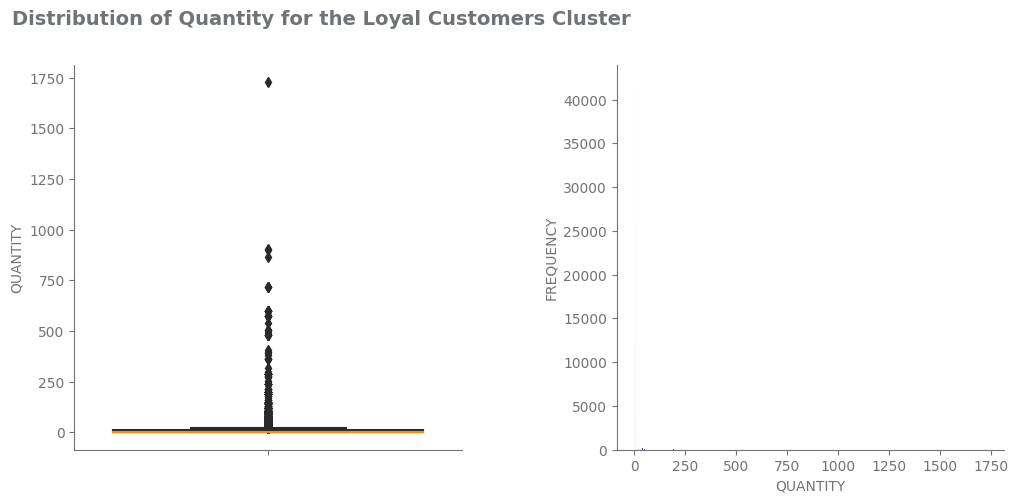

In [58]:
# Setting the figure and axes
fig, ax = plt.subplots(1, 2, figsize = (12, 5))

# Creating the box plot of quantity
sns.boxplot(y = 'Quantity', data = loyal_df, color = 'darkblue',
            medianprops = {'color' : 'darkorange'}, ax = ax[0])

# Creating the box plot of quantity
sns.histplot(x = 'Quantity', data = loyal_df, color = 'darkblue', ax = ax[1])

# Removing top and right spines from the plots
sns.despine(right = True)

# Customizing both plots
for i in range(len(ax)):
    ax[i].tick_params(color = '#6F7378') # Tick color
    plt.setp(ax[i].get_xticklabels(), color = '#6F7378') # y tick labels color
    plt.setp(ax[i].get_yticklabels(), color = '#6F7378') # x tick labels color
    for spine in ax[i].spines.values(): # spines color
        spine.set_edgecolor('#6F7378')
    if i == 0: # for the box plot
        ax[i].set_ylabel('QUANTITY', color = '#6F7378') # Renaming the y label and color
    else: # for the histogram
        ax[i].set_xlabel('QUANTITY', color = '#6F7378') # Renaming the x label and color
        ax[i].set_ylabel('FREQUENCY', color = '#6F7378') # Renaming the y label and color

# Adjusting the space between plots
plt.subplots_adjust(wspace = 0.4)

# Adding title
plt.suptitle('Distribution of Quantity for the Loyal Customers Cluster', size = 14, weight = 'bold',
             x = 0.331, y = 0.99, color = '#6F7378')

# Showing the plot
plt.show()

Unfortunately, our `Quantity` variable still contains high outliers, indicating several customers with higher item quantities in their purchases than most customers. For now, let's focus on the central tendency of this variable by zooming in to the central part of the distribution.

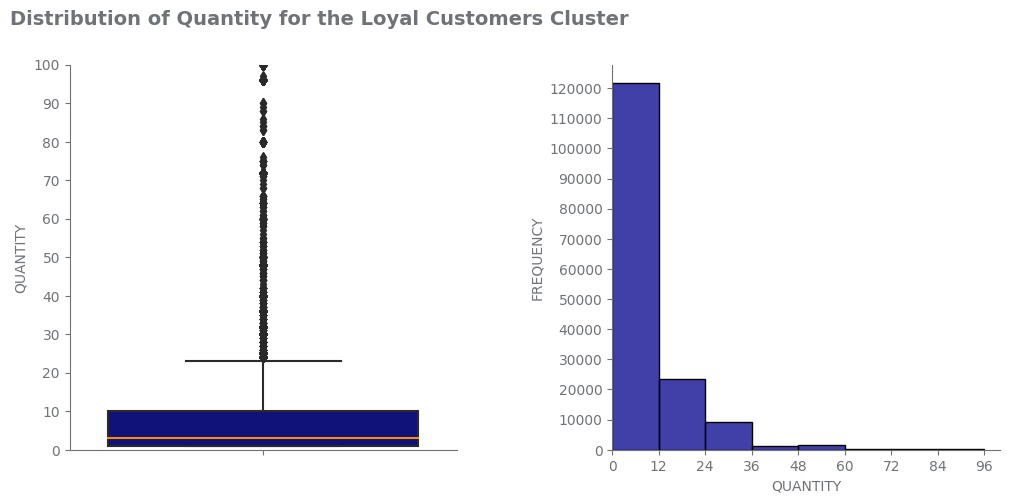

In [59]:
# Setting the figure and axes
fig, ax = plt.subplots(1, 2, figsize = (12, 5))

# Creating the box plot of quantity
sns.boxplot(y = 'Quantity', data = loyal_df, color = 'darkblue',
            medianprops = {'color' : 'darkorange'}, ax = ax[0])

# Creating the box plot of quantity
sns.histplot(x = 'Quantity', data = loyal_df, color = 'darkblue',
             bins = np.arange(0, 100, 12), ax = ax[1])

# Removing top and right spines from the plots
sns.despine(right = True)

# Customizing both plots
for i in range(len(ax)):
    ax[i].tick_params(color = '#6F7378') # Tick color
    plt.setp(ax[i].get_xticklabels(), color = '#6F7378') # y tick labels color
    plt.setp(ax[i].get_yticklabels(), color = '#6F7378') # x tick labels color
    for spine in ax[i].spines.values(): # spines color
        spine.set_edgecolor('#6F7378')
    if i == 0: # for the box plot
        ax[i].set_ylim(0, 100) # Limiting the y axis to zoom in and find the central part of the box
        ax[i].set_yticks(range(0, 101, 10)) # Adjusting the y ticks of the box plot
        ax[i].set_ylabel('QUANTITY', color = '#6F7378') # Renaming the y label and color
    else: # for the histogram
        ax[i].set_xlim(0, 100) # Limiting the x axis to zoom in and find the central part of the histogram
        ax[i].set_xticks(range(0, 101, 12)) # Adjusting the x ticks of the histogram
        ax[i].set_xlabel('QUANTITY', color = '#6F7378') # Renaming the x label and color
        ax[i].set_ylabel('FREQUENCY', color = '#6F7378') # Renaming the y label and color
        ax[i].set_yticks(range(0, 120001, 10000))

# Adjusting the space between plots
plt.subplots_adjust(wspace = 0.4)

# Adding title
plt.suptitle('Distribution of Quantity for the Loyal Customers Cluster', size = 14, weight = 'bold',
             x = 0.333, y = 0.99, color = '#6F7378')

# Showing the plot
plt.show()

Now that the central part of the box plot is clear, we can infer that typical individuals in the Loyal Customers cluster usually make purchases with quantities ranging from 1 to 11 items (reaching over 12K transactions). It's worth noting that there are a few outliers, representing purchases with quantities exceeding 24.

### Typical Product Price
Now, let's examine the typical price range of products customers purchase in the Loyal Customers cluster.

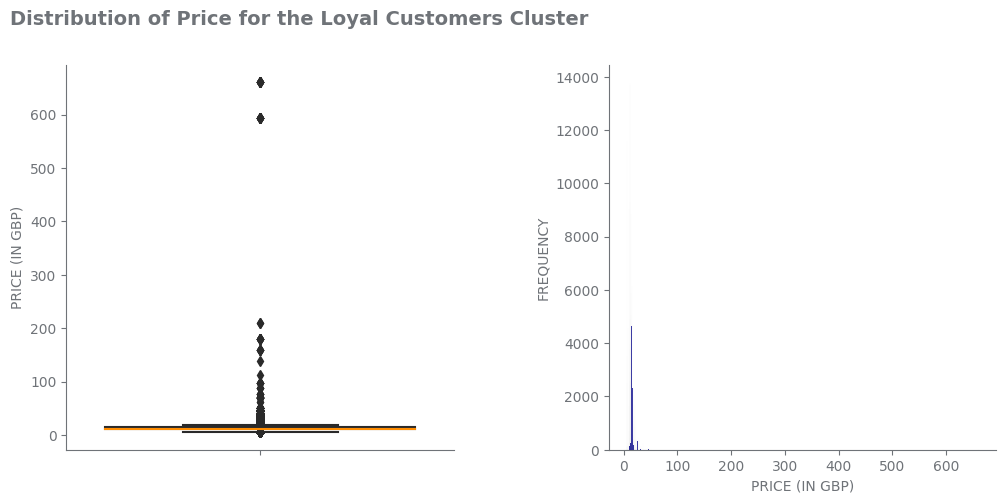

In [60]:
# Setting the figure and axes
fig, ax = plt.subplots(1, 2, figsize = (12, 5))

# Creating the box plot of quantity
sns.boxplot(y = 'Price', data = loyal_df, color = 'darkblue',
            medianprops = {'color' : 'darkorange'}, ax = ax[0])

# Creating the box plot of quantity
sns.histplot(x = 'Price', data = loyal_df, color = 'darkblue', ax = ax[1])

# Removing top and right spines from the plots
sns.despine(right = True)

# Customizing both plots
for i in range(len(ax)):
    ax[i].tick_params(color = '#6F7378') # Tick color
    plt.setp(ax[i].get_xticklabels(), color = '#6F7378') # y tick labels color
    plt.setp(ax[i].get_yticklabels(), color = '#6F7378') # x tick labels color
    for spine in ax[i].spines.values(): # spines color
        spine.set_edgecolor('#6F7378')
    if i == 0: # for the box plot
        ax[i].set_ylabel('PRICE (IN GBP)', color = '#6F7378') # Renaming the y label and color
    else: # for the histogram
        ax[i].set_xlabel('PRICE (IN GBP)', color = '#6F7378') # Renaming the x label and color
        ax[i].set_ylabel('FREQUENCY', color = '#6F7378') # Renaming the y label and color

# Adjusting the space between plots
plt.subplots_adjust(wspace = 0.4)

# Adding title
plt.suptitle('Distribution of Price for the Loyal Customers Cluster', size = 14, weight = 'bold',
             x = 0.319, y = 0.99, color = '#6F7378')

# Showing the plot
plt.show()

Again, our `Price` variable contains high outliers, indicating several customers who have purchased products with higher prices than most. For now, let's focus on the central tendency of this variable by zooming in to the central part of the distribution.

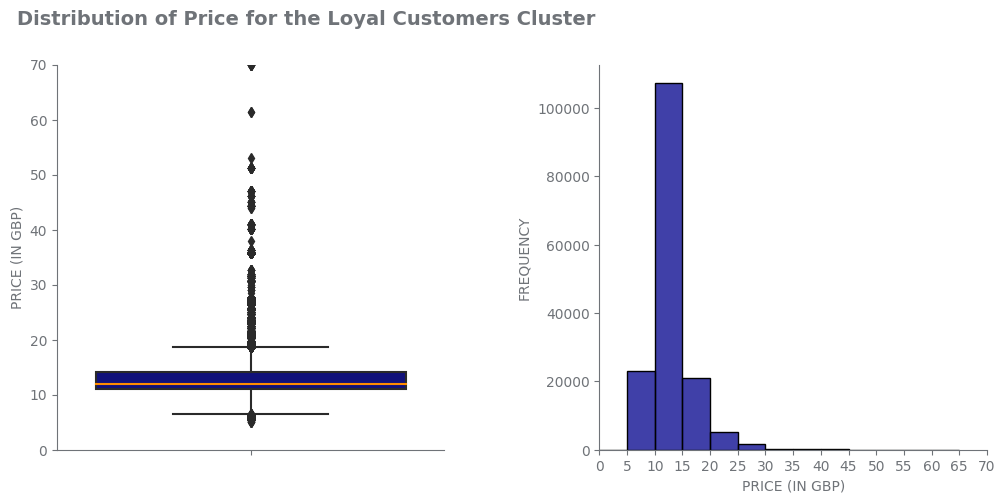

In [61]:
# Setting the figure and axes
fig, ax = plt.subplots(1, 2, figsize = (12, 5))

# Creating the box plot of quantity
sns.boxplot(y = 'Price', data = loyal_df, color = 'darkblue',
            medianprops = {'color' : 'darkorange'}, ax = ax[0])

# Creating the box plot of quantity
sns.histplot(x = 'Price', data = loyal_df, color = 'darkblue',
             bins = np.arange(0, 70, 5), ax = ax[1])

# Removing top and right spines from the plots
sns.despine(right = True)

# Customizing both plots
for i in range(len(ax)):
    ax[i].tick_params(color = '#6F7378') # Tick color
    plt.setp(ax[i].get_xticklabels(), color = '#6F7378') # y tick labels color
    plt.setp(ax[i].get_yticklabels(), color = '#6F7378') # x tick labels color
    for spine in ax[i].spines.values(): # spines color
        spine.set_edgecolor('#6F7378')
    if i == 0: # for the box plot
        ax[i].set_ylim(0, 70) # Limiting the y axis to zoom in and find the central part of the box
        ax[i].set_yticks(range(0, 71, 10)) # Adjusting the y ticks of the box plot
        ax[i].set_ylabel('PRICE (IN GBP)', color = '#6F7378') # Renaming the y label and color
    else: # for the histogram
        ax[i].set_xlim(0, 70) # Limiting the x axis to zoom in and find the central part of the histogram
        ax[i].set_xticks(range(0, 71, 5)) # Adjusting the x ticks of the histogram
        ax[i].set_xlabel('PRICE (IN GBP)', color = '#6F7378') # Renaming the x label and color
        ax[i].set_ylabel('FREQUENCY', color = '#6F7378') # Renaming the y label and color

# Adjusting the space between plots
plt.subplots_adjust(wspace = 0.4)

# Adding title
plt.suptitle('Distribution of Price for the Loyal Customers Cluster', size = 14, weight = 'bold',
             x = 0.333, y = 0.99, color = '#6F7378')

# Showing the plot
plt.show()

Now that the central part of the box plot is clear, we can deduce that typical individuals in the Loyal Customers cluster usually make purchases with products priced between 10-15 GBP. Notably, a few individuals make purchases with products priced more than 19 GBP, although this is rare.

### Typical Purchase Period (Month and Day of Week)
Now, let's delve into the typical purchase periods to analyze trends and understand when the Loyal Customers cluster tends to make purchases through a monthly and day-of-week analysis.

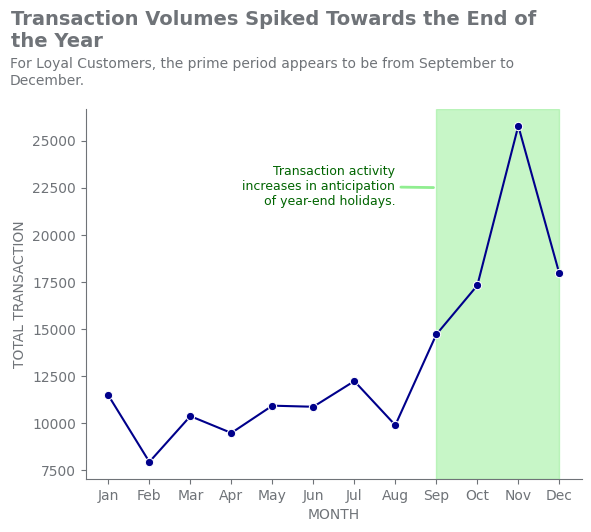

In [62]:
# Getting the total transaction frequency across month
monthly_trx = loyal_df['Month'].value_counts().to_frame().sort_index().reset_index()

# Adding abbreviated month column to be used in the visualization
monthly_trx['MonthAbb'] = [calendar.month_abbr[mon] for mon in monthly_trx['Month']]

# Setting the figure and axes
fig, ax = plt.subplots()

# Creating the line plot
sns.lineplot(x = 'MonthAbb', y = 'count', data = monthly_trx, 
             color = 'darkblue', ax = ax,  marker = 'o')

# Removing the top and right spines
sns.despine(right = True)

# Changing the tick color
ax.tick_params(color = '#6F7378') 

# Changing the x and y tick labels colors
plt.setp(ax.get_xticklabels(), color = '#6F7378') 
plt.setp(ax.get_yticklabels(), color = '#6F7378') 

# Setting the label names of both axes
ax.set_xlabel('MONTH', color = '#6F7378')
ax.set_ylabel('TOTAL TRANSACTION', color = '#6F7378')

# Changing the spines colors
for spine in ax.spines.values():
    spine.set_edgecolor('#6F7378')
    
# Adding rectangle background color to emphasize the 'peak' time
ax.axvspan(8, 11, color = 'lightgreen', alpha = .5)

# Adding titles and annotations
ax.set_title('Transaction Volumes Spiked Towards the End of\nthe Year', size = 14, weight = 'bold',
          pad = 45, ha = 'left', x = -0.15, color = '#6F7378')
ax.text(-2.4, 28000, "For Loyal Customers, the prime period appears to be from September to\nDecember.",
        color = '#6F7378')
ax.annotate('Transaction activity\nincreases in anticipation\nof year-end holidays.', xy = [8, 22500], 
            xytext = [7, 21600], size = 9, ha = 'right', color = 'darkgreen', 
            arrowprops = {'arrowstyle':'-', 
                          'color':'lightgreen', 
                          'linewidth':2})

# Showing the plot
plt.show()

As observed in the plot, the peak period for loyal customers occurs towards the end of the year, particularly from September to December. While the total transactions during these months are significantly higher than in the preceding months, there is a sudden decrease in December. This decrease might suggest that customers, anticipating the holiday rush and logistical challenges, tend to complete their holiday purchases in November. The busy logistics around December, especially near Christmas and New Year's Eve, could lead to delays.

Next, let's zoom in to the day of the week dimension.

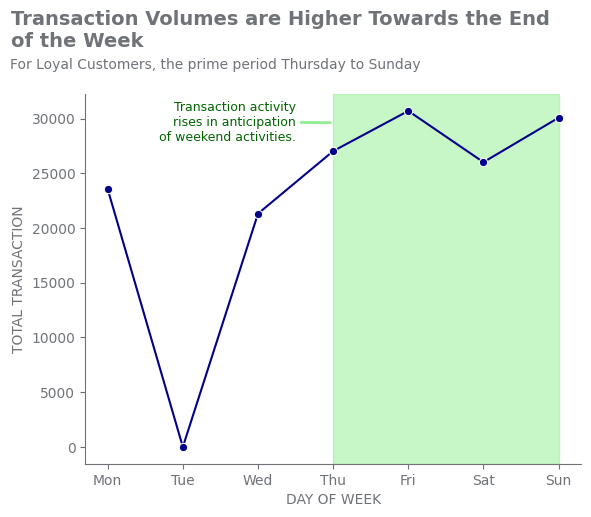

In [63]:
# Getting the total transaction frequency across month
dow_trx = loyal_df['DayOfWeek'].value_counts().to_frame().sort_index().reset_index()

# Adding abbreviated month column to be used in the visualization
dow_trx['DowAbb'] = [calendar.day_abbr[day] for day in dow_trx['DayOfWeek']]

# Because there are no records of transactions in Tuesday, we're going to add it manually with 0 transactions
tue = pd.DataFrame(dict(DayOfWeek = [1], count = [0], DowAbb = ['Tue']))
dow_trx = pd.concat([dow_trx, tue], ignore_index = True).sort_values('DayOfWeek').reset_index(drop = True)

# Setting the figure and axes
fig, ax = plt.subplots()

# Creating the line plot
sns.lineplot(x = 'DowAbb', y = 'count', data = dow_trx, 
             color = 'darkblue', ax = ax,  marker = 'o')

# Removing the top and right spines
sns.despine(right = True)

# Changing the tick color
ax.tick_params(color = '#6F7378') 

# Changing the x and y tick labels colors
plt.setp(ax.get_xticklabels(), color = '#6F7378') 
plt.setp(ax.get_yticklabels(), color = '#6F7378') 

# Setting the label names of both axes
ax.set_xlabel('DAY OF WEEK', color = '#6F7378')
ax.set_ylabel('TOTAL TRANSACTION', color = '#6F7378')

# Changing the spines colors
for spine in ax.spines.values():
    spine.set_edgecolor('#6F7378')
    
# Adding rectangle background color to emphasize the 'peak' time
ax.axvspan(3, 6, color = 'lightgreen', alpha = .5)

# Adding plot title and annotations
ax.set_title('Transaction Volumes are Higher Towards the End\nof the Week', size = 14, weight = 'bold',
             pad = 34, ha = 'left', x = -0.15, color = '#6F7378')
ax.text(-1.3, 34500, "For Loyal Customers, the prime period Thursday to Sunday", color = '#6F7378')
ax.annotate('Transaction activity\nrises in anticipation\nof weekend activities.', xy = [3, 29630], 
            xytext = [2.5, 28000], size = 9, ha = 'right', color = 'darkgreen', 
            arrowprops = {'arrowstyle':'-', 
                          'color':'lightgreen', 
                          'linewidth':2})

# Showing the plot
plt.show()

Once again, the day-of-week dimension reveals that transactions peak towards the end of the week, particularly from Thursday to Sunday. This insight suggests that people make purchases in anticipation of weekend activities, ensuring they have their desired products to enjoy over the weekend by the end of the week.

On the flip side, one anomaly has captured our attention: Transactions on Tuesday are nonexistent. As inspected in the initial Exploratory Data Analysis (EDA), the store seems to be closed on Tuesdays because transactions on Tuesdays are missing in the whole data.

# Closing: Business Recommendations
Now that we've identified the cluster to target, potentially bringing in more revenue for the company, and have examined their characteristics and buying habits, we can formulate several business recommendations to leverage this information:

1. BULK PRICING AND TIERED POINT SYSTEM

    **BENEFITS: Increased Revenue and Customer Satisfaction**
   
     - Introduce bulk pricing for their top-selling products, which will be discounted if they reach several threshold quantities of items. We will need to assess further our Cost of Goods Sold by Products and the Profit Margins to plan the bulk pricing system. We may need to discuss this matter further with the Pricing & Merchandising department.
     - Implement a tiered loyalty point system for their preferred items to encourage increased purchases. The tier could be classified into Bronze, Silver, and Gold customers. As their tier increases, they will have more benefits, too. The progression of each tier will be based on their frequency of purchases. We may need to discuss this matter further with the loyalty/retention (if there are any) or marketing departments.
    

2. E-COMMERCE FRONT PAGE PERSONALIZATION

    **BENEFITS: Increased Sales, Conversion, and Customer Experience/Engagement**
   
     - We can put the top-selling products on the front page and the firstmost section where customers will see them directly on the e-commerce landing page for users in this cluster. The products shown could vary by the categories. For example, the top purchased product is the Cream Hanging Heart T-Light Holder, which is categorized as a home decor. We can further show similar light holder products besides this product and the same for their other top purchased products. We may need to discuss this idea further with the Merchandising or Product Management departments.


3. SEPARATE SECTION FOR PRODUCTS UNDER £15

    **BENEFITS: Increased Sales, Conversion, and Customer Experience/Engagement**
   
     - Because the typical price range of purchased products in this cluster is around 10-15 GBP, we can make it easier for them to find products for less than £15 by creating an independent section on the e-commerce home page that contains products according to their top-selling categories. This section could be named "Under £15!" to attract them and contains their most purchased items and similar items depending on the category. Discussion with the Merchandising or Product Management departments will be possibly needed.
     - Create a monthly event inside this section where if the customer reaches a threshold amount of spending, they will get a benefit like, for example, free delivery on the next purchase. The form of offers could vary, and we will need to collaborate further with the Marketing department to develop this idea.


4. INCREASE PUSH EMAIL CAMPAIGNS AT THE END OF THE YEAR
    
    **BENEFITS: Increased Sales, Revenue, and Conversion**
    
     - Increase push email campaigns from September to December, particularly at the weekend from Thursday to Sunday. The type of campaign recommended is Lead Nurturing Campaigns, which "nurtures" them toward a purchase of their top-selling products, seeing that their buying power is the highest at this period based on their transaction frequency. To develop this action further, we need to collaborate with the Marketing or Digital Marketing departments.
    
    
5. CURATED PRODUCT BUNDLES

    **BENEFITS: Increased Sales, Revenue, and Customer Experience and Loyalty**
   
      - Create curated product bundles around the end of the year, like "Party Poppers For New Year's Eve," which contains home decor, party supplies, and kitchenwares accompanied by exclusive New Year cards. We can offer this bundle to be more personalized based on their family size, marital status, and spending total. Still, we need more data about their family members and marital status. We also need to develop the pricing to be competitive but maintain a fair profit margin. We must collaborate with the Product/Merchandising and Marketing/Branding departments.
   
   
6. WEEKEND CAMPAIGN

    **BENEFITS: Increased Customer Engagement and Loyalty**
   
    - Introduce a "Weekend Bargains" campaign at the end of the week, offering incentives such as double loyalty points, discounts on their best-selling products, or reduced delivery costs. Review past data on campaign acceptance/use rates or conduct a survey among the Loyal Customers sample to determine the most effective campaign type to understand their preferred offers. Once the preferred type is identified, calculate the campaign cost and adjust the profit margin accordingly. We need to collaborate with the Marketing and Finance departments.

*These recommendations are only for customers in the Loyal Customers cluster.*